In [1]:
#basic necessary Python modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Colin's taufit module, GitHub: https://github.com/burke86/taufit
from taufit import fit_drw 
from taufit import hampel_filter
#need celerite, emcee, and corner. these can be installed using pip.
import statsmodels.api as sm

#necessary AstroPy modules
from astropy.io import ascii
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import concatenate
from astropy.coordinates import search_around_sky
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, MaskedColumn
from astropy.table import QTable

#importing ALCpy
import ALCpy as ALC
import pandas as pd

def lc_sorter(fits_file, ipac_file):
    lcFULL = fits.open(fits_file) #fits_file should be string, i.e 'LIU_lc.fits'
    lcdata = lcFULL[1].data
    phot_mask = lcdata['catflags'] < 32768
    lcdata = lcdata[phot_mask]
    
    lc_coord = ascii.read(ipac_file) #ipac_file should be string, i.e 'matched_IPAC_LIU.txt'
    lc_ra = np.array(lc_coord['ra'])*u.degree
    lc_de = np.array(lc_coord['dec'])*u.degree
    lc_matchcoord = SkyCoord(lc_ra, lc_de)
    
    band_datara = lcdata['ra']*u.degree
    band_datade = lcdata['dec']*u.degree
    band_datacoord = SkyCoord(band_datara, band_datade)
    
    lc_idx, band_idx, d2d, d3d = search_around_sky(lc_matchcoord, band_datacoord, 0.5*u.arcsec)
    
    #find where the the index in lc_idx changes, this change should indicate different coordinates and thus differents LCs.
    k = 0
    temp_change = []
    while k < len(lc_idx):
        if lc_idx[k] == lc_idx[k-1]:
            k += 1
        else:
            temp_change.append(k)
            k += 1
    temp_change.append(len(lc_idx))

    
    diff_idx = []
    z = 0
    while z < len(lc_idx):
        if lc_idx[z] == lc_idx[z-1]:
            z += 1
        else:
            diff_idx.append(lc_idx[z])
            z += 1
    
    temp_idx = [[] for x in range(len(lc_matchcoord))] #good indexes
    j = 0
    y = 0
    while j+1 < len(temp_change):
        if y in diff_idx:
            temp_idx[y] = band_idx[temp_change[j] : temp_change[j+1]] 
            j += 1
            y += 1
        else:
            y += 1
            
    coord_mask = []
    j = 0
    while j < len(temp_idx):
        if len(temp_idx[j]) == 0:
            j += 1
        else:
            coord_mask.append(j)
            j += 1
    
    print('sorted!')
    
    i = 0
    mjd = []
    mag = []
    err = []
    
    while i < len(temp_idx):
        mjd.append(lcdata['mjd'][temp_idx[i]])
        mag.append(lcdata['mag'][temp_idx[i]])
        err.append(lcdata['magerr'][temp_idx[i]])
        i += 1
    
    return mjd, mag, err, coord_mask

def argsort(mjd, mag, err):
    mjdfin = []
    magfin = []
    errfin = []
    
    k = 0
    while k < len(mjd):
        maskfin = np.argsort(mjd[k])
        mjdfin.append(mjd[k][maskfin])
        magfin.append(mag[k][maskfin])
        errfin.append(err[k][maskfin])
        k += 1
    
    return mjdfin, magfin, errfin

#######

def p2sigma(p):
    import numpy as np
    import scipy.stats as st
    log_p = np.log(p)
    if (log_p > -36):
        sigma = st.norm.ppf(1 - p/2)
    else:
        sigma = np.sqrt(np.log(2/np.pi) - 2*np.log(8.2) - 2*log_p)
    return sigma

########

import statsmodels.api as sm

def timing_analysis(mjd, mag, err, names, oridx, nburn_val, nsamp_val, var_filename):
    
    hampel_parse = 0
    hampel_mjd = []
    hampel_mag = []
    hampel_err = []
    
    while hampel_parse < len(mjd):
        mjd_new, mag_new, mask_bool = hampel_filter(np.array(mjd)[hampel_parse], np.array(mag)[hampel_parse], 365)
        err_parse = np.array(err)[hampel_parse]
        err_new = np.array(err_parse)[~mask_bool]
        
        hampel_mjd.append(mjd_new)
        hampel_mag.append(mag_new)
        hampel_err.append(err_new)
        hampel_parse += 1
    
    parse = 0
    
    tau_drw = []
    tau_drw_lo = []
    tau_drw_hi = []
    
    sigma_drwlist = []
    sigma_drw_lo = []
    sigma_drw_hi = []
    
    sigma_nlist = []
    sigma_n_lo = []
    sigma_n_hi = []
    
    sigma_wnlist = []
    SNR = []
    pvalue_list = []
    sigma_lblist = []
    
    while parse < len(hampel_mjd):
        gp, samples, fig = fit_drw(np.array(hampel_mjd)[parse]*u.day, np.array(hampel_mag)[parse]*u.mag, 
                                   yerr = np.array(hampel_err)[parse]*u.mag, target_name = names[parse] +' '+ oridx[parse], 
                                   plot = True, nburn = nburn_val, nsamp = nsamp_val)
        
        tau_val = 1/np.exp(np.median(samples[:,1]))
        tau_lo = tau_val - np.percentile(1/np.exp(samples[:,1]), 16)
        tau_hi = np.percentile(1/np.exp(samples[:,1]), 84) - tau_val
        tau_drw.append(tau_val)
        tau_drw_lo.append(tau_lo)
        tau_drw_hi.append(tau_hi)
        
        sigma_drw = np.median(np.sqrt(np.exp(samples[:,0])/2))
        sigmadrw_lo = np.median(np.sqrt(np.exp(np.percentile(samples[:,0], 16))/2))
        sigmadrw_hi = np.median(np.sqrt(np.exp(np.percentile(samples[:,0], 84))/2))
        sigma_drwlist.append(sigma_drw)
        sigma_drw_lo.append(sigmadrw_lo)
        sigma_drw_hi.append(sigmadrw_hi)
        
        sigma_n = np.median(np.sqrt(np.exp(samples[:,2])/2))
        sigman_lo = np.median(np.sqrt(np.exp(np.percentile(samples[:,2], 16))/2))
        sigman_hi = np.median(np.sqrt(np.exp(np.percentile(samples[:,2], 84))/2))
        sigma_nlist.append(sigma_n)
        sigma_n_lo.append(sigman_lo)
        sigma_n_hi.append(sigman_hi)
        
        sigma_wn =  np.sqrt(np.mean(hampel_err[parse])**2 + np.median(np.exp(samples[:,2]))**2)
        sigma_wnlist.append(sigma_wn)
        
        snr_val = sigma_drw/sigma_wn
        SNR.append(snr_val)
        rounded_snr = "{:.1f}".format(snr_val)
        
        try:
            lbval, p_val = sm.stats.acorr_ljungbox(hampel_mag[parse])
            pvalue_list.append(p_val[-1])
        
            sigma_lb = p2sigma(p_val[-1])
            sigma_lblist.append(sigma_lb)
            rounded_sigma = "{:.1f}".format(sigma_lb)
        
        except ValueError:
            pvalue_list.append('ValueError')
            sigma_lb = 'ValueError'
            sigma_lblist.append(sigma_lb)
            rounded_sigma = 0.0
            pass
        
        ax_lc = fig.axes[-2]
        ax_lc.text(0.03, 0.93, r'SNR = %s, $\sigma_{\rm{LB}}$ = %s' %(rounded_snr, rounded_sigma), transform = ax_lc.transAxes, fontsize = 20)
        
        fig.savefig('%s page_%d_sigma.pdf' %(names[parse], parse), dpi = 300, bbox_inches = 'tight')
        
        print('fit_drw has completed %s out of %d iterations' %(parse+1, len(mjd)))
        parse += 1
    
    ascii.write([tau_drw, tau_drw_lo, tau_drw_hi, sigma_drwlist, sigma_drw_lo, sigma_drw_hi,
                 sigma_nlist, sigma_n_lo, sigma_n_hi, sigma_wnlist, SNR, pvalue_list, sigma_lblist], 
                '%s.txt' %var_filename, 
                names=['tau', 'tau_lo', 'tau_hi', 'sigma_drw', 'sigma_drw_lo', 'sigma_drw_hi',
                       'sigma_n', 'sigma_n_lo', 'sigma_n_hi', 'sigma_wn', 'SNR', 'pvalue', 'sigma_lb'], format = 'ipac')
    
    return tau_drw

In [2]:
def gerr(med_mag_nested, err_or_nested):
    new_err = []
    i = 0
    while i < len(med_mag_nested):
        med_mag = np.array(med_mag_nested[i])
        err_or = np.array(err_or_nested[i])
        
        sigma = 0.0007417*med_mag**4 - 0.0485*med_mag**3 + 1.191*med_mag**2 - 13.03*med_mag + 53.6
        quad = np.sqrt(err_or**2 + sigma**2)
        
        new_err.append(quad)
        i += 1
    return new_err

In [3]:
LIU_coord = ascii.read('matched_IPAC_HE2.txt') #https://iopscience.iop.org/article/10.3847/1538-4365/aab88e
GH_coord = ascii.read('matched_IPAC_GH_fin.txt') #https://iopscience.iop.org/article/10.1086/522082
RV_coord = ascii.read('matched_IPAC_RV_fin.txt') #https://iopscience.iop.org/article/10.1088/0004-637X/813/2/82
CKZ_coord = ascii.read('matched_IPAC_CKZ_fin.txt') #https://iopscience.iop.org/article/10.3847/1538-4357/aad184

LIU_ra = np.array(LIU_coord['ra'])
LIU_de = np.array(LIU_coord['dec'])

GH_ra = np.array(GH_coord['ra'])
GH_de = np.array(GH_coord['dec'])

RV_ra = np.array(RV_coord['ra'])
RV_de = np.array(RV_coord['dec'])

CKZ_ra = np.array(CKZ_coord['ra'])
CKZ_de = np.array(CKZ_coord['dec'])

#######################################################################

LIU_mjdraw, LIU_magraw, LIU_errraw, LIU_coordmask = lc_sorter('LIU18_zg6.fits', 'matched_IPAC_HE_fin.txt')

LIU_ra = np.array(LIU_coord['ra'])[LIU_coordmask]
LIU_de = np.array(LIU_coord['dec'])[LIU_coordmask]
LIU_oridx = [str(x) for x in np.array(LIU_coord['ID'])[LIU_coordmask]]
LIU_names = np.full(len(LIU_oridx), 'Liu+18')
LIU_mjd1 = np.array(LIU_mjdraw)[LIU_coordmask]
LIU_mag1 = np.array(LIU_magraw)[LIU_coordmask]
LIU_err1 = np.array(LIU_errraw)[LIU_coordmask]

LIU_mjd2, LIU_mag2, LIU_err2 = argsort(LIU_mjd1, LIU_mag1, LIU_err1)

final_LIUidx = []
j = 0
while j < len(LIU_mjd2):
    if len(LIU_mjd2[j]) > 5:
        final_LIUidx.append(j)
        j += 1
    else:
        j += 1

LIU_mjdfin = np.array(LIU_mjd2)[final_LIUidx]
LIU_magfin = np.array(LIU_mag2)[final_LIUidx]
LIU_errfin = np.array(LIU_err2)[final_LIUidx]
#new error
LIU_errfin = gerr(LIU_magfin, LIU_errfin)
#########
LIU_ra = LIU_ra[final_LIUidx]
LIU_de = LIU_de[final_LIUidx]
LIU_oridx = np.array(LIU_oridx)[final_LIUidx]
LIU_names = LIU_names[final_LIUidx]

#LIU_tau = timing_analysis(LIU_mjdfin, LIU_magfin, LIU_errfin, LIU_names, LIU_oridx, 500, 2000, 'LIU18_zgvar62')

#######################################################################

GH_mjdraw, GH_magraw, GH_errraw, GHcoord_mask = lc_sorter('GH07_zg6.fits', 'matched_IPAC_GH_fin.txt')

GH_ra = np.array(GH_coord['ra'])[GHcoord_mask]
GH_de = np.array(GH_coord['dec'])[GHcoord_mask]
GH_oridx = [str(x) for x in np.array(GH_coord['ID'])[GHcoord_mask]]
GH_names = np.full(len(GH_oridx), 'GH07')
GH_mjd1 = np.array(GH_mjdraw)[GHcoord_mask]
GH_mag1 = np.array(GH_magraw)[GHcoord_mask]
GH_err1 = np.array(GH_errraw)[GHcoord_mask]

GH_mjd2, GH_mag2, GH_err2 = argsort(GH_mjd1, GH_mag1, GH_err1)

final_GHidx = []
j = 0
while j < len(GH_mjd2):
    if len(GH_mjd2[j]) > 5:
        final_GHidx.append(j)
        j += 1
    else:
        j += 1

GH_mjdfin = np.array(GH_mjd2)[final_GHidx]
GH_magfin = np.array(GH_mag2)[final_GHidx]
GH_errfin = np.array(GH_err2)[final_GHidx]
####
GH_errfin = gerr(GH_magfin, GH_errfin)
####
GH_ra = GH_ra[final_GHidx]
GH_de = GH_de[final_GHidx]
GH_oridx = np.array(GH_oridx)[final_GHidx]
GH_names = GH_names[final_GHidx]

#GH_tau = timing_analysis(GH_mjdfin, GH_magfin, GH_errfin, GH_names, GH_oridx, 500, 2000, 'GH07_zgvar62')

#######################################################################

RV_mjdraw, RV_magraw, RV_errraw, RV_coordmask = lc_sorter('RV15_zg6.fits', 'matched_IPAC_RV_fin.txt')

RV_ra = np.array(RV_coord['ra'])[RV_coordmask]
RV_de = np.array(RV_coord['dec'])[RV_coordmask]
RV_oridx = [str(x) for x in np.array(RV_coord['ID'])[RV_coordmask]]
RV_names = np.full(len(RV_oridx), 'RV15')
RV_mjd1 = np.array(RV_mjdraw)[RV_coordmask]
RV_mag1 = np.array(RV_magraw)[RV_coordmask]
RV_err1 = np.array(RV_errraw)[RV_coordmask]

RV_mjd2, RV_mag2, RV_err2 = argsort(RV_mjd1, RV_mag1, RV_err1)

final_RVidx = []
j = 0
while j < len(RV_mjd2):
    if len(RV_mjd2[j]) > 5:
        final_RVidx.append(j)
        j += 1
    else:
        j += 1
        
RV_mjdfin = np.array(RV_mjd2)[final_RVidx]
RV_magfin = np.array(RV_mag2)[final_RVidx]
RV_errfin = np.array(RV_err2)[final_RVidx]
####
RV_errfin = gerr(RV_magfin, RV_errfin)
####
RV_ra = RV_ra[final_RVidx]
RV_de = RV_de[final_RVidx]
RV_oridx = np.array(RV_oridx)[final_RVidx]
RV_names = RV_names[final_RVidx]

#RV_tau = timing_analysis(RV_mjdfin, RV_magfin, RV_errfin, RV_names, RV_oridx, 500, 2000, 'RV15_zgvar62')

#######################################################################

CKZ_mjdraw, CKZ_magraw, CKZ_errraw, CKZ_coordmask = lc_sorter('CKZ18_zg6.fits', 'matched_IPAC_CKZ_fin.txt')

CKZ_ra = np.array(CKZ_coord['ra'])[CKZ_coordmask]
CKZ_de = np.array(CKZ_coord['dec'])[CKZ_coordmask]
CKZ_oridx = [str(x) for x in np.array(CKZ_coord['ID'])[CKZ_coordmask]]
CKZ_names = np.full(len(CKZ_oridx), 'Chilingarian+18')
CKZ_mjd1 = np.array(CKZ_mjdraw)[CKZ_coordmask]
CKZ_mag1 = np.array(CKZ_magraw)[CKZ_coordmask]
CKZ_err1 = np.array(CKZ_errraw)[CKZ_coordmask]

CKZ_mjd2, CKZ_mag2, CKZ_err2 = argsort(CKZ_mjd1, CKZ_mag1, CKZ_err1)

final_CKZidx = []
j = 0
while j < len(CKZ_mjd2):
    if len(CKZ_mjd2[j]) > 5:
        final_CKZidx.append(j)
        j += 1
    else:
        j += 1

CKZ_mjdfin = np.array(CKZ_mjd2)[final_CKZidx]
CKZ_magfin = np.array(CKZ_mag2)[final_CKZidx]
CKZ_errfin = np.array(CKZ_err2)[final_CKZidx]
####
CKZ_errfin = gerr(CKZ_magfin, CKZ_errfin)
####
CKZ_ra = CKZ_ra[final_CKZidx]
CKZ_de = CKZ_de[final_CKZidx]
CKZ_oridx = np.array(CKZ_oridx)[final_CKZidx]
CKZ_names = CKZ_names[final_CKZidx]

#CKZ_tau = timing_analysis(CKZ_mjdfin, CKZ_magfin, CKZ_errfin, CKZ_names, CKZ_oridx, 500, 2000, 'CKZ18_zgvar62')

#######################################################################

sorted!


<ipython-input-3-fb87f2f1808b>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mjd1 = np.array(LIU_mjdraw)[LIU_coordmask]
<ipython-input-3-fb87f2f1808b>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mag1 = np.array(LIU_magraw)[LIU_coordmask]
<ipython-input-3-fb87f2f1808b>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  

sorted!


<ipython-input-3-fb87f2f1808b>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  GH_mjd1 = np.array(GH_mjdraw)[GHcoord_mask]
<ipython-input-3-fb87f2f1808b>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  GH_mag1 = np.array(GH_magraw)[GHcoord_mask]
<ipython-input-3-fb87f2f1808b>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  GH_err

sorted!


<ipython-input-3-fb87f2f1808b>:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RV_mjd1 = np.array(RV_mjdraw)[RV_coordmask]
<ipython-input-3-fb87f2f1808b>:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RV_mag1 = np.array(RV_magraw)[RV_coordmask]
<ipython-input-3-fb87f2f1808b>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RV_er

sorted!


<ipython-input-3-fb87f2f1808b>:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CKZ_mjd1 = np.array(CKZ_mjdraw)[CKZ_coordmask]
<ipython-input-3-fb87f2f1808b>:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CKZ_mag1 = np.array(CKZ_magraw)[CKZ_coordmask]
<ipython-input-3-fb87f2f1808b>:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [4]:
print(len(GH_mjdfin))
print(GH_ra[95], GH_de[95])
print(GH_ra[115], GH_de[115])

#GH_tau = timing_analysis(GH_mjdfin[[95, 115]], GH_magfin[[95, 115]], GH_errfin[[95, 115]], GH_names[[95, 115]], GH_oridx[[95, 115]], 500, 2000, 'duplicates')

214
160.54177446 -0.30410267
173.181621 10.342516


In [4]:
def baseline(nested_mjd):
    baseline_list = []
    for time in nested_mjd:
        baseline_list.append(time[-1] - time[0])
    return baseline_list

def cadence(nested_mjd):
    cadence_list = []
    for time in nested_mjd:
        cadence_list.append(np.mean(np.diff(time)))
    return cadence_list

LIU_var = ascii.read('LIU18_zgvar62.txt')
LIU_siglbraw = np.array(LIU_var['sigma_lb'])

LIU_coridx = [int(x)-1 for x in LIU_oridx]
LIU_data1 = ascii.read('HE18.txt')
LIU_data2 = ascii.read('HE_mass.txt')
LIU_massraw = np.array(LIU_data2['MBH'])[LIU_coridx]
LIU_redsraw = np.array(LIU_data1['zspec'])[LIU_coridx]

LIU_tauraw = np.array(LIU_var['tau'])
LIU_tauLraw = np.array(LIU_var['tau_lo'])
LIU_tauHraw = np.array(LIU_var['tau_hi'])
LIU_sigDraw = np.array(LIU_var['sigma_drw'])
LIU_snr1raw = np.array(LIU_var['SNR'])

LIU_badidx = []
i = 0
while i < len(LIU_siglbraw):
    if LIU_siglbraw[i] == 'ValueError':
        LIU_badidx.append(i)
        i += 1
    else:
        i += 1

LIU_goodidx = []
for idx in np.arange(0, len(LIU_siglbraw), 1):
    if idx not in LIU_badidx:
        LIU_goodidx.append(idx)

LIU_siglb = []
for x in LIU_siglbraw[LIU_goodidx]:
    val = float(x)
    LIU_siglb.append(val)

LIU_mass = LIU_massraw[LIU_goodidx]
LIU_reds = LIU_redsraw[LIU_goodidx]
LIU_tau = LIU_tauraw[LIU_goodidx]
LIU_taulo = LIU_tauLraw[LIU_goodidx]
LIU_tauhi = LIU_tauHraw[LIU_goodidx]
LIU_sigdrw = LIU_sigDraw[LIU_goodidx]
LIU_snrraw = LIU_snr1raw[LIU_goodidx]

GH_var = ascii.read('GH07_zgvar62.txt')
GH_siglbraw = np.array(GH_var['sigma_lb'])

GH_coridx = [int(x)-1 for x in GH_oridx]
GH_data1 = ascii.read('GH07.txt')
GH_data2 = ascii.read('GH_mass.txt')
GH_massraw = np.array(GH_data2['logM'])[GH_coridx]
GH_redsraw = np.array(GH_data1['z'])[GH_coridx]

GH_tauraw = np.array(GH_var['tau'])
GH_tauLraw = np.array(GH_var['tau_lo'])
GH_tauHraw = np.array(GH_var['tau_hi'])
GH_sigDraw = np.array(GH_var['sigma_drw'])
GH_snr1raw = np.array(GH_var['SNR'])

GH_badidx = []
i = 0
while i < len(GH_siglbraw):
    if GH_siglbraw[i] == 'ValueError':
        GH_badidx.append(i)
        i += 1
    else:
        i += 1

GH_goodidx = []
for idx in np.arange(0, len(GH_siglbraw), 1):
    if idx not in GH_badidx:
        GH_goodidx.append(idx)

GH_siglb = []
for x in GH_siglbraw[GH_goodidx]:
    val = float(x)
    GH_siglb.append(val)

GH_mass = GH_massraw[GH_goodidx]
GH_reds = GH_redsraw[GH_goodidx]
GH_tau = GH_tauraw[GH_goodidx]
GH_taulo = GH_tauLraw[GH_goodidx]
GH_tauhi = GH_tauHraw[GH_goodidx]
GH_sigdrw = GH_sigDraw[GH_goodidx]
GH_snrraw = GH_snr1raw[GH_goodidx]

RV_coridx = [int(x)-1 for x in RV_oridx]
RV_data2 = ascii.read('RV15.txt')
RV_mass = np.array(RV_data2['logMBH'])[RV_coridx]
RV_reds = np.array(RV_data2['z'])[RV_coridx]

RV_var = ascii.read('RV15_zgvar62.txt')
RV_tauraw = np.array(RV_var['tau'])
RV_taulo = np.array(RV_var['tau_lo'])
RV_tauhi = np.array(RV_var['tau_hi'])
RV_sigdrw = np.array(RV_var['sigma_drw'])
RV_snrraw = np.array(RV_var['SNR'])
RV_siglbraw = np.array(RV_var['sigma_lb'])

CKZ_var = ascii.read('CKZ18_zgvar62.txt')
CKZ_siglbraw = np.array(CKZ_var['sigma_lb'])

CKZ_coridx = [int(x)-1 for x in CKZ_oridx]
CKZ_data2 = fits.open('CKZ18.fits')
CKZ_data3 = CKZ_data2[1].data
CKZ_massraw = np.log10(CKZ_data3['MBH'])[CKZ_coridx]
CKZ_redsraw = np.array(CKZ_data3['z'])[CKZ_coridx]

CKZ_tauraw = np.array(CKZ_var['tau'])
CKZ_tauLraw = np.array(CKZ_var['tau_lo'])
CKZ_tauHraw = np.array(CKZ_var['tau_hi'])
CKZ_sigDraw = np.array(CKZ_var['sigma_drw'])
CKZ_snr1raw = np.array(CKZ_var['SNR'])

CKZ_badidx = []
i = 0
while i < len(CKZ_siglbraw):
    if CKZ_siglbraw[i] == 'ValueError':
        CKZ_badidx.append(i)
        i += 1
    else:
        i += 1

CKZ_goodidx = []
for idx in np.arange(0, len(CKZ_siglbraw), 1):
    if idx not in CKZ_badidx:
        CKZ_goodidx.append(idx)

CKZ_siglb = []
for x in CKZ_siglbraw[CKZ_goodidx]:
    val = float(x)
    CKZ_siglb.append(val)

CKZ_mass = CKZ_massraw[CKZ_goodidx]
CKZ_reds = CKZ_redsraw[CKZ_goodidx]
CKZ_tau = CKZ_tauraw[CKZ_goodidx]
CKZ_taulo = CKZ_tauLraw[CKZ_goodidx]
CKZ_tauhi = CKZ_tauHraw[CKZ_goodidx]
CKZ_sigdrw = CKZ_sigDraw[CKZ_goodidx]
CKZ_snrraw = CKZ_snr1raw[CKZ_goodidx]

names_list = LIU_names[LIU_goodidx].tolist() + GH_names[GH_goodidx].tolist() + RV_names.tolist() + CKZ_names[CKZ_goodidx].tolist()
oridx_list = LIU_oridx[LIU_goodidx].tolist() + GH_oridx[GH_goodidx].tolist() + RV_oridx.tolist() + CKZ_oridx[CKZ_goodidx].tolist()
ra_list = LIU_ra[LIU_goodidx].tolist() + GH_ra[GH_goodidx].tolist() + RV_ra.tolist() + CKZ_ra[CKZ_goodidx].tolist()
de_list = LIU_de[LIU_goodidx].tolist() + GH_de[GH_goodidx].tolist() + RV_de.tolist() + CKZ_de[CKZ_goodidx].tolist()
mass_list = LIU_mass.tolist() + GH_mass.tolist() + RV_mass.tolist() + CKZ_mass.tolist()
reds_list = LIU_reds.tolist() + GH_reds.tolist() + RV_reds.tolist() + CKZ_reds.tolist()
tau_list = LIU_tau.tolist() + GH_tau.tolist() + RV_tauraw.tolist() + CKZ_tau.tolist()
tau_rest1 = ((1/(1+np.array(reds_list)))*np.array(tau_list)).tolist()
baselines = baseline(LIU_mjdfin[LIU_goodidx]) + baseline(GH_mjdfin[GH_goodidx]) + baseline(RV_mjdfin) + baseline(CKZ_mjdfin[CKZ_goodidx])
cadences = cadence(LIU_mjdfin[LIU_goodidx]) + cadence(GH_mjdfin[GH_goodidx]) + cadence(RV_mjdfin) + cadence(CKZ_mjdfin[CKZ_goodidx])
sigmalb_list = LIU_siglb + GH_siglb + RV_siglbraw.tolist() + CKZ_siglb
sigmaD_list = LIU_sigdrw.tolist() + GH_sigdrw.tolist() + RV_sigdrw.tolist() + CKZ_sigdrw.tolist()
snr_list = LIU_snrraw.tolist() + GH_snrraw.tolist() + RV_snrraw.tolist() + CKZ_snrraw.tolist()
gme_list = (np.full(len(LIU_names[LIU_goodidx]), 0.30)).tolist() + (np.full(len(GH_names[GH_goodidx]), 0.30)).tolist() + (np.full(len(RV_names), 0.5)).tolist() + (np.full(len(CKZ_names[CKZ_goodidx]), 0.3)).tolist()

tau_hi = LIU_tauhi.tolist() + GH_tauhi.tolist() + RV_tauhi.tolist() + CKZ_tauhi.tolist()
tau_lo = LIU_taulo.tolist() + GH_taulo.tolist() + RV_taulo.tolist() + CKZ_taulo.tolist()
dtau = []
j = 0
while j < len(tau_hi):
    dtau_val = np.mean([tau_hi[j], tau_lo[j]])
    dtau.append(dtau_val)
    j += 1

dlogtau = 0.434*(np.array(dtau)/np.array(tau_list))
dlogtau_list = dlogtau.tolist()

table_1 = QTable([names_list, oridx_list, ra_list, de_list, mass_list, gme_list, reds_list, tau_rest1, 
                  dlogtau_list, sigmalb_list, sigmaD_list, snr_list, baselines, cadences], 
                 names = ('catalog', 'oridx', 'ra', 'dec', 'mass', 'mass_err', 'z', 'tau', 'dlogtau', 'sigma_lb', 
                          'sigma_drw', 'SNR', 'baseline', 'cadence'),
                 meta = {'name':'first table'})

table_1

ascii.write(table_1, 'parentG.txt', format = 'ipac')
print(len(table_1))
mags = LIU_magfin[LIU_goodidx].tolist() + GH_magfin[GH_goodidx].tolist() + RV_magfin.tolist() + CKZ_magfin[CKZ_goodidx].tolist()
med_mag = [np.median(x) for x in mags]
magtab = Table([med_mag], names = ['med_mag'])
#print(med_mag)
ascii.write(magtab, 'mags.txt', format = 'ipac')

885


In [5]:
table_1

catalog,oridx,ra,dec,mass,mass_err,z,tau,dlogtau,sigma_lb,sigma_drw,SNR,baseline,cadence
str15,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Liu+18,1,85.70309,0.67201,6.24,0.3,0.0518,0.13617016129738,0.5238756607362665,1.578602887555268,0.08323845753869295,1.418207570964784,912.7270022999946,7.481368871311432
Liu+18,2,115.93947,48.13709,5.48,0.3,0.0181,4.846805669804407,0.7756540319289651,3.846400095274034,0.023974940710847565,0.4672639227049753,1124.9730903000018,4.517964218072296
Liu+18,3,122.02972,56.64234,6.14,0.3,0.099,106.3424477062667,0.7085093113642335,11.418904604029413,0.03202349133810686,0.5683207768407605,1124.0361458999978,4.84498338749999
Liu+18,4,122.13909,54.08923,6.05,0.3,0.2848,290.12404661761514,1.136654242376108,14.332936524506787,0.12775593345597322,0.7935257541550449,1097.9784259000007,7.5722650062069015
Liu+18,5,122.29468,11.10531,5.95,0.3,0.0526,11.325488062207931,0.3415436611795611,3.463686694168849,0.06543710967754371,1.0888600284612089,1101.0238542000006,7.921034922302163
Liu+18,6,124.32739,52.02992,6.3,0.3,0.0386,6.388609477835162,0.8632135108371713,0.6758159276191277,0.06841300662852307,1.1270101903210137,421.0880208000017,18.30817481739138
Liu+18,7,124.88909,23.28465,6.24,0.3,0.094,0.2083266974898513,0.46116789514901996,2.5863026423933806,0.08480611118807682,1.151957557861904,1114.9317592000007,4.664986440167366
Liu+18,8,126.26247,11.17262,6.24,0.3,0.1077,2.7989598311765236,14.133977860854927,0.9749363479324602,0.05033585858639082,0.5038323357425291,1122.0067013999942,10.486043938317703
Liu+18,9,126.72634,23.59384,6.2,0.3,0.1369,0.23391380012650514,2.226195213430296,1.3223072849226356,0.033676768591325915,0.5083970507808033,1068.958715300003,15.492155294202941


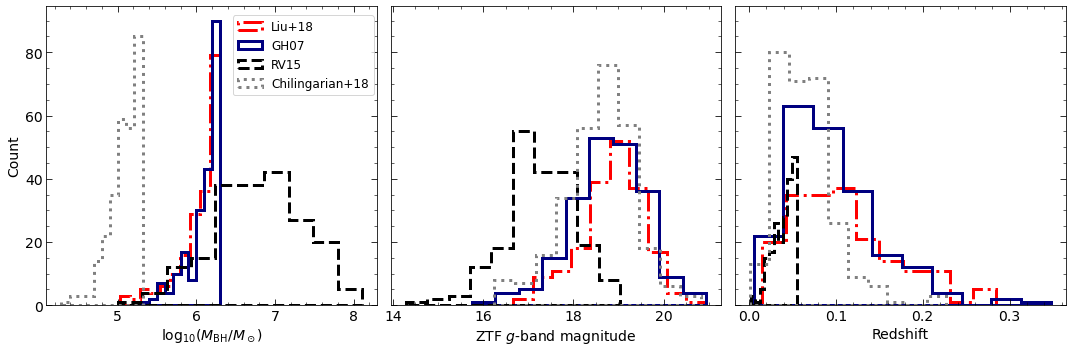

In [6]:
fig, (axmass, axmags, axreds) = plt.subplots(1, 3, sharey = True)
axmass.hist(LIU_mass, label = 'Liu+18', edgecolor = 'r', density = False, ls = 'dashdot', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmass.hist(GH_mass, label = 'GH07', edgecolor = 'navy', density = False, ls = 'solid', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmass.hist(RV_mass, label = 'RV15', edgecolor = 'k', density = False, ls = 'dashed', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmass.hist(CKZ_mass, label = 'Chilingarian+18', edgecolor = 'grey', density = False, ls = 'dotted', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')

axmags.hist([np.median(x) for x in LIU_magfin[LIU_goodidx]], edgecolor = 'r', density = False, ls = 'dashdot', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmags.hist([np.median(x) for x in GH_magfin[GH_goodidx]], edgecolor = 'navy', density = False, ls = 'solid', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmags.hist([np.median(x) for x in RV_magfin], edgecolor = 'k', density = False, ls = 'dashed', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axmags.hist([np.median(x) for x in CKZ_magfin[CKZ_goodidx]], edgecolor = 'grey', density = False, ls = 'dotted', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')

axreds.hist(LIU_reds, label = 'Liu+18', edgecolor = 'r', density = False, ls = 'dashdot', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axreds.hist(GH_reds, label = 'GH07', edgecolor = 'navy', density = False, ls = 'solid', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axreds.hist(RV_reds, label = 'RV15', edgecolor = 'k', density = False, ls = 'dashed', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
axreds.hist(CKZ_reds, label = 'Chilingarian+18', edgecolor = 'grey', density = False, ls = 'dotted', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')

axmass.set_xlabel(r'$\log_{10 }(M_{\rm{BH}}/M_\odot)$', fontsize = 14)
axmass.set_ylabel('Count', fontsize = 14)
axmags.set_xlabel('ZTF $g$-band magnitude', fontsize = 14)
axreds.set_xlabel('Redshift', fontsize = 14)
#axmass.set_xticklabels(np.arange(4.0, 8.5, 0.5), fontsize = 14)
#axmags.set_xticklabels(np.arange(14, 22, 1), fontsize = 14)
#axreds.tick_params(axis='x', labelsize=14)
#axmass.tick_params(axis='y', labelsize=14)
#axmass.set_yticklabels(np.arange(0.0, 3.5, 0.5), fontsize = 14)
#axmags.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize = 14)

axmass.minorticks_on()
axmags.minorticks_on()
axreds.minorticks_on()
axmass.tick_params(axis='both', which='both', direction='in', labelsize = 14)
axmags.tick_params(axis='both', which='both', direction='in', labelsize = 14)
axreds.tick_params(axis='both', which='both', direction='in', labelsize = 14)
axmass.tick_params(axis='both', which='major', length=6)
axmass.tick_params(axis='both', which='minor', length=3)
axmags.tick_params(axis='both', which='major', length=6)
axmags.tick_params(axis='both', which='minor', length=3)
axreds.tick_params(axis='both', which='major', length=6)
axreds.tick_params(axis='both', which='minor', length=3)
axmass.xaxis.set_ticks_position('both')
axmass.yaxis.set_ticks_position('both')
axmags.xaxis.set_ticks_position('both')
axmags.yaxis.set_ticks_position('both')
axreds.xaxis.set_ticks_position('both')
axreds.yaxis.set_ticks_position('both')

fig.subplots_adjust(right = 3.0)
fig.set_size_inches(15, 5.0)
fig.tight_layout()
axmass.legend(bbox_to_anchor = (0.545, 0.99), fontsize = 12)
plt.savefig('fig_1.pdf', dpi = 300, bbox_inches = 'tight')

In [108]:
new = ascii.read('CKZ18_zrvar62.txt')
old = ascii.read('CKZ18_zrvar6.txt')

new_snr = np.array(new['SNR'])
old_snr = np.array(old['SNR'])

old_snr1 = []
for snr in old_snr:
    if snr > 1:
        old_snr1.append(snr)
    
snr1 = new['SNR'] > 1
lbnew = np.array(new['sigma_drw'])[snr1]
print(np.mean(lbnew))

snr2 = old['SNR'] > 1
lbold = np.array(old['sigma_drw'])[snr2]
print(np.mean(lbold))

dnew = []
j = 0
while j < len(np.array(new['tau_hi'])):
    dnew_val = np.mean([np.array(new['tau_hi'])[j], np.array(new['tau_lo'])[j]])
    dnew.append(dnew_val)
    j += 1

dynew = 0.434*(np.array(dnew)/np.array(new['tau']))
print(np.mean(dynew[snr1]))

dold = []
j = 0
while j < len(np.array(old['tau_hi'])):
    dold_val = np.mean([np.array(old['tau_hi'])[j], np.array(old['tau_lo'])[j]])
    dold.append(dold_val)
    j += 1

dyold = 0.434*(np.array(dold)/np.array(old['tau']))
print(np.mean(dyold[snr2]))

print(dynew[snr1])
#fig, ax1 = plt.subplots()
#ax1.hist(new_snr, label = 'corrected', edgecolor = 'r', density = False, ls = 'dashdot', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
#ax1.hist(old_snr, label = 'before correction',  edgecolor = 'navy', density = False, ls = 'solid', lw = 3, fc=(0, 0, 1, 0), histtype='stepfilled')
#ax1.set_xlabel(r'snr', fontsize = 14)
#ax1.set_ylabel('Count', fontsize = 14)
#ax1.legend()

0.09888288057625551
0.05748237873298931
0.1619925434800522
2.917799370331924
[0.16199254]


In [5]:
colin_test = ascii.read('colin_data.csv')
col_ra = np.array(colin_test['RA'])[[58, 59]]
col_de = np.array(colin_test['DEC.'])[[58, 59]]

col_skycoord = SkyCoord(col_ra*u.degree, col_de*u.degree)
par_skycoord = SkyCoord(np.array(ra_list)*u.degree, np.array(de_list)*u.degree)

col_idx, par_idx, d2d, d3d = search_around_sky(col_skycoord, par_skycoord, 0.5*u.arcsec)
print(col_skycoord)
print(par_idx)

par2_skycoord = SkyCoord(ra_good*u.degree, de_good*u.degree)
col_idx, par2_idx, d2d, d3d = search_around_sky(col_skycoord, par2_skycoord, 0.5*u.arcsec)

print(table_1[649]['sigma_lb'])
print(table_1[649]['SNR'])
print('done')
print(table_1[649]['tau'])
print(table_1[649]['baseline'])
print(table_1[649]['cadence'])
print(table_1[649]['ra'])
print(table_1[797]['catalog'])
print(table_1[797]['oridx'])

<SkyCoord (ICRS): (ra, dec) in deg
    [(233.6066,  4.1352), (241.3827, 17.8073)]>
[370 656 178 807]


NameError: name 'ra_good' is not defined

In [7]:
BL_constraint = table_1['tau'] < 0.1*table_1['baseline'] #usually x 0.1
CA_constraint = table_1['tau'] > table_1['cadence']
dlog_constraint = table_1['dlogtau'] < 1.2

SNR_hi = table_1['SNR'] > 1.0
sigma_LBhi = table_1['sigma_lb'] > 3.0

name_good = np.array(names_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
oridx_good = np.array(oridx_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
ra_good = np.array(ra_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
de_good = np.array(de_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
mass_good = np.array(mass_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
z_good = np.array(reds_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
tau_good = np.array(tau_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
tau_rest = (1/(1+z_good))*tau_good
dlog_good = np.array(dlogtau_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
sigmalb_good = np.array(sigmalb_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
sigmaD_good = np.array(sigmaD_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
snr_good = np.array(snr_list)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
baseline_good = np.array(baselines)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
cadence_good = np.array(cadences)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]

table_sorted = QTable([name_good, oridx_good, ra_good, de_good, mass_good, tau_rest, 
                       sigmalb_good, sigmaD_good, snr_good, baseline_good, cadence_good], 
                      names = ('catalog', 'oridx', 'ra', 'dec', 'mass', 'tau', 'siglb', 'sigD', 'snr', 'baseline', 'cadence'),
                      meta = {'name':'first table'})

table_sorted


catalog,oridx,ra,dec,mass,tau,siglb,sigD,snr,baseline,cadence
str15,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64
Liu+18,5,122.29468,11.10531,5.95,11.325488062207931,3.463686694168849,0.06543710967754371,1.0888600284612089,1101.0238542000006,7.921034922302163
Liu+18,33,143.53584,17.94556,5.69,10.444028213049439,11.897552507919293,0.06477051797240616,1.2642386907135723,1125.9189120999945,7.263992981290287
Liu+18,34,143.77839,14.97909,6.04,77.74503074398412,21.668469668039766,0.10157932736958719,1.4850014221307433,1125.9568172,9.964219621238938
Liu+18,39,148.08376,32.47412,6.29,16.66667086921692,11.032735676906807,0.055423301690536046,1.0637084894741602,1125.937523200002,5.601679219900507
Liu+18,87,181.80626,27.36378,6.2,79.16925457908069,22.688088455225536,0.07734154798334814,1.0018835283189182,1125.009548599999,4.591875708571425
Liu+18,125,200.32909,30.07328,6.28,69.43942017662553,inf,0.07470616254838372,1.2211479468411466,1127.0410416999948,2.4934536320796346
Liu+18,135,205.64859,26.25945,6.18,48.67479949982828,20.665900971728913,0.1078806447997796,1.9003709394752781,1094.9307869999975,7.064069593548371
Liu+18,148,213.52093,26.56023,6.16,90.97020311678726,30.032075657347505,0.1268707275194376,2.1609342668193947,1126.9971644000034,6.192292112087931
Liu+18,173,226.26005,13.03378,6.19,41.09546354349432,11.647133208370535,0.08660637575431868,1.1666524219716736,1123.9120601999966,9.137496424390216


In [8]:
LIU_rasort = ra_good[name_good == 'Liu+18']
LIU_desort = de_good[name_good == 'Liu+18']
LIU_skycoord = SkyCoord(LIU_rasort*u.degree, LIU_desort*u.degree)

GH_rasort = ra_good[name_good == 'GH07']
GH_desort = de_good[name_good == 'GH07']
GH_skycoord = SkyCoord(GH_rasort*u.degree, GH_desort*u.degree)

RV_rasort = ra_good[name_good == 'RV15']
RV_desort = de_good[name_good == 'RV15']
RV_skycoord = SkyCoord(RV_rasort*u.degree, RV_desort*u.degree)

CKZ_rasort = ra_good[name_good == 'Chilingarian+18']
CKZ_desort = de_good[name_good == 'Chilingarian+18']
CKZ_skycoord = SkyCoord(CKZ_rasort*u.degree, CKZ_desort*u.degree)

LIU_matchidxG, GH_matchidxL, d2d, d3d = search_around_sky(LIU_skycoord, GH_skycoord, 0.5*u.arcsec)
LIU_matchidxR, RV_matchidxL, d2d, d3d = search_around_sky(LIU_skycoord, RV_skycoord, 0.5*u.arcsec)
LIU_matchidxC, CKZ_matchidxL, d2d, d3d = search_around_sky(LIU_skycoord, CKZ_skycoord, 0.5*u.arcsec)

CKZ_matchidxG, GH_matchidxC, d2d, d3d = search_around_sky(CKZ_skycoord, GH_skycoord, 0.5*u.arcsec)
CKZ_matchidxR, RV_matchidxC, d2d, d3d = search_around_sky(CKZ_skycoord, RV_skycoord, 0.5*u.arcsec)

RV_matchidxG, GH_matchidxR, d2d, d3d = search_around_sky(RV_skycoord, GH_skycoord, 0.5*u.arcsec)

def dup_finder(ra, matchidx):
    duped_idx = []
    for x in np.arange(0, len(ra), 1):
        if x not in matchidx:
            duped_idx.append(x)
    return duped_idx

# out of the following, see which aren't empty. add those together to respective catalog.
#print(GH_matchidxL)
#print(RV_matchidxL)
#print(CKZ_matchidxL)
#print(GH_matchidxC)
#print(RV_matchidxC)
#print(GH_matchidxR)

RV_badidx = RV_matchidxL.tolist() + RV_matchidxC.tolist() #add together the corresponding non-empty lists, duplicates.
RV_badidx.sort()
RV_goodidx = dup_finder(RV_rasort, RV_badidx)

#for finding g-band and r-band data:
LIU_namefin = name_good[name_good == 'Liu+18']
GH_namefin = name_good[name_good == 'GH07']
RV_namefin = name_good[name_good == 'RV15'][RV_goodidx]
CKZ_namefin = name_good[name_good == 'Chilingarian+18']

LIU_oridxfin = oridx_good[name_good == 'Liu+18']
GH_oridxfin = oridx_good[name_good == 'GH07']
RV_oridxfin = oridx_good[name_good == 'RV15'][RV_goodidx]
CKZ_oridxfin = oridx_good[name_good == 'Chilingarian+18']

RV_rafin = RV_rasort[RV_goodidx]
RV_defin = RV_desort[RV_goodidx]

#for tau-mass plot:
LIU_massfin = mass_good[name_good == 'Liu+18']
GH_massfin = mass_good[name_good == 'GH07']
RV_massfin = mass_good[name_good == 'RV15'][RV_goodidx]
CKZ_massfin = mass_good[name_good == 'Chilingarian+18']

LIU_taufin = tau_rest[name_good == 'Liu+18']
GH_taufin = tau_rest[name_good == 'GH07']
RV_taufin = tau_rest[name_good == 'RV15'][RV_goodidx]
CKZ_taufin = tau_rest[name_good == 'Chilingarian+18']

LIU_zfin = z_good[name_good == 'Liu+18']
GH_zfin = z_good[name_good == 'GH07']
RV_zfin = z_good[name_good == 'RV15'][RV_goodidx]
CKZ_zfin = z_good[name_good == 'Chilingarian+18']

LIU_dlogfin = dlog_good[name_good == 'Liu+18']
GH_dlogfin = dlog_good[name_good == 'GH07']
RV_dlogfin = dlog_good[name_good == 'RV15'][RV_goodidx]
CKZ_dlogfin = dlog_good[name_good == 'Chilingarian+18']

totmasslist = LIU_massfin.tolist() + GH_massfin.tolist() + RV_massfin.tolist() + CKZ_massfin.tolist()
tottaulist = LIU_taufin.tolist() + GH_taufin.tolist() + RV_taufin.tolist() + CKZ_taufin.tolist()
totdloglist = LIU_dlogfin.tolist() + GH_dlogfin.tolist() + RV_dlogfin.tolist() + CKZ_dlogfin.tolist()
totnamelist = LIU_namefin.tolist() + GH_namefin.tolist() + RV_namefin.tolist() + CKZ_namefin.tolist()

table_fin = QTable([totnamelist, totmasslist, tottaulist, totdloglist], 
                      names = ('name', 'mass', 'tau', 'dlog'),
                      meta = {'name':'first table'})

totmass = np.array(totmasslist)
tottau = np.array(tottaulist)
totdlog = np.array(totdloglist)
totname = np.array(totnamelist)

#everything for the csv file

totoridlist = LIU_oridxfin.tolist() + GH_oridxfin.tolist() + RV_oridxfin.tolist() + CKZ_oridxfin.tolist()
totra = LIU_rasort.tolist() + GH_rasort.tolist() + RV_rasort[RV_goodidx].tolist() + CKZ_rasort.tolist()
totde = LIU_desort.tolist() + GH_desort.tolist() + RV_desort[RV_goodidx].tolist() + CKZ_desort.tolist()
totz = LIU_zfin.tolist() + GH_zfin.tolist() + RV_zfin.tolist() + CKZ_zfin.tolist()

LIU_baseline = baseline_good[name_good == 'Liu+18']
GH_baseline = baseline_good[name_good == 'GH07']
RV_baseline = baseline_good[name_good == 'RV15'][RV_goodidx]
CKZ_baseline = baseline_good[name_good == 'Chilingarian+18']

LIU_cadence = cadence_good[name_good == 'Liu+18']
GH_cadence = cadence_good[name_good == 'GH07']
RV_cadence = cadence_good[name_good == 'RV15'][RV_goodidx]
CKZ_cadence = cadence_good[name_good == 'Chilingarian+18']

LIU_sigmaD = sigmaD_good[name_good == 'Liu+18']
GH_sigmaD = sigmaD_good[name_good == 'GH07']
RV_sigmaD = sigmaD_good[name_good == 'RV15'][RV_goodidx]
CKZ_sigmaD = sigmaD_good[name_good == 'Chilingarian+18']

LIU_sigmaL = sigmalb_good[name_good == 'Liu+18']
GH_sigmaL = sigmalb_good[name_good == 'GH07']
RV_sigmaL = sigmalb_good[name_good == 'RV15'][RV_goodidx]
CKZ_sigmaL = sigmalb_good[name_good == 'Chilingarian+18']

LIU_snr = snr_good[name_good == 'Liu+18']
GH_snr = snr_good[name_good == 'GH07']
RV_snr = snr_good[name_good == 'RV15'][RV_goodidx]
CKZ_snr = snr_good[name_good == 'Chilingarian+18']

totbase = LIU_baseline.tolist() + GH_baseline.tolist() + RV_baseline.tolist() + CKZ_baseline.tolist()
totcade = LIU_cadence.tolist() + GH_cadence.tolist() + RV_cadence.tolist() + CKZ_cadence.tolist()
totsigd = LIU_sigmaD.tolist() + GH_sigmaD.tolist() + RV_sigmaD.tolist() + CKZ_sigmaD.tolist()
totsigl = LIU_sigmaL.tolist() + GH_sigmaL.tolist() + RV_sigmaL.tolist() + CKZ_sigmaL.tolist()
totsnr = LIU_snr.tolist() + GH_snr.tolist() + RV_snr.tolist() + CKZ_snr.tolist()
totgme = (np.full(len(LIU_massfin), 0.30)).tolist() + (np.full(len(GH_massfin), 0.30)).tolist() + (np.full(len(RV_massfin), 0.50)).tolist() + np.array([0.07]).tolist()

fin_ipac = Table([totnamelist, totoridlist, totra, totde, totmass, 
                  tottau, totdlog, totbase, totcade, totsigd, totsigl, totsnr, totz, totgme],
                  names = ['name', 'oridx', 'ra', 'dec', 'mass', 
                           'tau', 'dlog', 'baseline', 'cadence', 'sigma_drw', 'sigma_lb', 'SNR', 'z', 'totgme'])
ascii.write(fin_ipac, 'fincsv_G.txt', format = 'ipac')

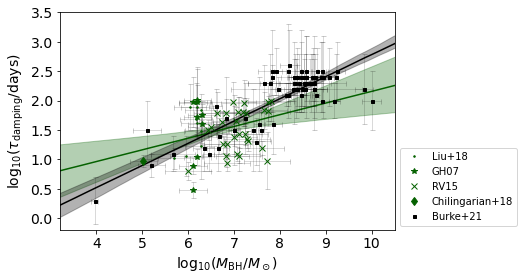

In [9]:
import linmix

def draws_CI_linmix(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i,s in enumerate(samples):
        draws[:, i]  = s['alpha'] + x_eval*s['beta']
    # Compute credibility interval
    draws_credint = np.empty((len(x_eval), 3))
    draws_credint[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint[:, 1] = np.median(draws, axis=1)
    return draws_credint

logM_lm = totmass
logT_lm = np.log10(tottau)
logDt_lm = totdlog
logDm_lm = np.full(len(logDt_lm), 0.4).tolist()

lm = linmix.LinMix(np.array(logM_lm), np.array(logT_lm),
                   xsig = np.array(logDt_lm), ysig = np.array(logDm_lm),
                   K = 2, nchains = 4, seed = np.random.randint(2**31))
lm.run_mcmc(silent = True)
samples_fin = lm.chain

x_eval = np.linspace(0,15,50)
draws_credint = draws_CI_linmix(x_eval, samples_fin)
plt.fill_between(x_eval, draws_credint[:, 2], draws_credint[:, 0], color="#056100", alpha=0.3, zorder=-5)
plt.plot(x_eval, draws_credint[:, 1], color="#056100", zorder=-4)

LIU_mass = totmass[totname == 'Liu+18']
LIU_tau = tottau[totname == 'Liu+18']
LIU_dlog = totdlog[totname == 'Liu+18']

GH_mass = totmass[totname == 'GH07']
GH_tau = tottau[totname == 'GH07']
GH_dlog = totdlog[totname == 'GH07']

RV_mass = totmass[totname == 'RV15']
RV_tau = tottau[totname == 'RV15']
RV_dlog = totdlog[totname == 'RV15']

CKZ_mass = totmass[totname == 'Chilingarian+18']
CKZ_tau = tottau[totname == 'Chilingarian+18']
CKZ_dlog = totdlog[totname == 'Chilingarian+18']

markL, barL, capL = plt.errorbar(LIU_mass, np.log10(LIU_tau), xerr = 0.35, yerr = LIU_dlog, markersize = 3, 
                              fmt ='.', c ='#056100', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Liu+18')

[b.set_alpha(0.2) for b in barL]
[c.set_alpha(0.2) for c in capL] #0.2

markG, barG, capG = plt.errorbar(GH_mass, np.log10(GH_tau), xerr = 0.3, yerr = GH_dlog, 
                              fmt ='*', c ='#056100', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'GH07')


[b.set_alpha(0.2) for b in barG]
[c.set_alpha(0.2) for c in capG]

markR, barR, capR = plt.errorbar(RV_mass, np.log10(RV_tau), xerr = 0.5, yerr = RV_dlog, 
                              fmt ='x', c ='#056100', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'RV15')

[b.set_alpha(0.2) for b in barR]
[c.set_alpha(0.2) for c in capR]


markC, barC, capC = plt.errorbar(CKZ_mass, np.log10(CKZ_tau), xerr = 0.3, yerr = CKZ_dlog, 
                              fmt ='d', c ='#056100', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Chilingarian+18')

[b.set_alpha(0.2) for b in barC]
[c.set_alpha(0.2) for c in capC]


########
colin_data = ascii.read('colin_data.csv')
CB_massraw = np.array(colin_data['log_M_BH'])
CB_tauraw = np.array(colin_data['log_tau_DRW_rest'])

CB_mass = []
CB_masserr = []
for data in CB_massraw:
    mass_val = data[0] + data[1] + data[2] + data[3]
    err_val = data[8] + data[9] + data[10] + data[11]
    CB_mass.append(float(mass_val))
    CB_masserr.append(float(err_val))

CB_tau = []
CB_tauerr = []
for data in CB_tauraw:
    tau_val = data[0] + data[1] + data[2]
    err_val = data[7] + data[8] + data[9]
    CB_tau.append(float(tau_val))
    CB_tauerr.append(float(err_val))

mark, bar, cap = plt.errorbar(CB_mass, CB_tau, xerr = CB_masserr, yerr = CB_tauerr, markersize = 3,
                              fmt ='s', c ='k', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Burke+21')

[b.set_alpha(0.2) for b in bar]
[c.set_alpha(0.2) for c in cap]
########


########
CB_alpha = np.random.normal(107, 11.5, 200)
CB_beta = np.random.normal(0.38, 0.045, 200)
samples_CB = []

p = 0
while p < len(CB_alpha):
    samples_CB.append((CB_alpha[p], CB_beta[p]))
    p += 1
    
CB_samplefin = np.array(samples_CB, dtype=[('alpha', np.float64), ('beta', np.float64)])

def draws_CI_linmix2(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i, s in enumerate(samples):
        draws[:,i] = np.log10(s['alpha']*(10**x_eval/1e8)**s['beta'])
        
    # Compute credibility interval
    draws_credint2 = np.empty((len(x_eval), 3))
    draws_credint2[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint2[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint2[:, 1] = np.median(draws, axis=1)
    return draws_credint2

x_eval2 = np.linspace(0,15,200)
draws_credint2 = draws_CI_linmix2(x_eval2, CB_samplefin)
plt.fill_between(x_eval2, draws_credint2[:, 2], draws_credint2[:, 0], color="k", alpha=0.3, zorder=-5)
plt.plot(x_eval2, draws_credint2[:, 1], color="k", zorder=-4)
#########

#WD_mass = np.log10([0.79432823, 0.72443596, 0.54954087, 0.47863009, 0.58884366, 0.54954087, 0.67608298, 0.75857758])
#WD_tau = np.log10([0.00663572, 0.00591409, 0.01705642, 0.01451737, 0.01418691, 0.00874758, 0.00409155, 0.00895134])
#plt.plot(WD_mass, WD_tau, 'm+', markersize = 15)#, label = 'white dwarfs')

plt.xlabel(r'$\log_{10 }(M_{\rm{BH}}/M_\odot)$', fontsize = 14)
plt.ylabel(r"$\log_{10}(\tau_{\rm{damping}}$/days)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(3.2, 10.5) #(3.2, 10.5)
plt.ylim(-0.2, 3.5) #(-0.2, 3.5)
ax1 = plt.gca()
handles, labels = ax1.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax1.legend(handles, labels, loc='upper left', numpoints=1, bbox_to_anchor = (1.0, 0.4))
plt.savefig('taurestmass_fixedZG.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [9]:
print(np.amax(RV_mass), np.amin(RV_mass))

7.8 5.99


In [12]:
LIU_raG = np.array(totra)[totname == 'Liu+18']
LIU_deG = np.array(totde)[totname == 'Liu+18']

GH_raG = np.array(totra)[totname == 'GH07']
GH_deG = np.array(totde)[totname == 'GH07']

RV_raG = np.array(totra)[totname == 'RV15']
RV_deG = np.array(totde)[totname == 'RV15']

CKZ_raG = np.array(totra)[totname == 'Chilingarian+18']
CKZ_deG = np.array(totde)[totname == 'Chilingarian+18']

LIU_Gdata = Table([LIU_mass, LIU_tau, LIU_dlog, LIU_raG, LIU_deG], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(LIU_Gdata, 'LIU_masstauG62.txt', format = 'ipac')

GH_Gdata = Table([GH_mass, GH_tau, GH_dlog, GH_raG, GH_deG], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(GH_Gdata, 'GH_masstauG62.txt', format = 'ipac')

RV_Gdata = Table([RV_mass, RV_tau, RV_dlog, RV_raG, RV_deG], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(RV_Gdata, 'RV_masstauG62.txt', format = 'ipac')

CKZ_Gdata = Table([CKZ_mass, CKZ_tau, CKZ_dlog, CKZ_raG, CKZ_deG], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(CKZ_Gdata, 'CKZ_masstauG62.txt', format = 'ipac')

In [9]:
mjds = LIU_mjdfin[LIU_goodidx].tolist() + GH_mjdfin[GH_goodidx].tolist() + RV_mjdfin.tolist() + CKZ_mjdfin[CKZ_goodidx].tolist()
mags = LIU_magfin[LIU_goodidx].tolist() + GH_magfin[GH_goodidx].tolist() + RV_magfin.tolist() + CKZ_magfin[CKZ_goodidx].tolist()
errs = LIU_errfin[LIU_goodidx].tolist() + GH_errfin[GH_goodidx].tolist() + RV_errfin.tolist() + CKZ_errfin[CKZ_goodidx].tolist()
mjdcsv = np.array(mjds)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
magcsv = np.array(mags)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
errcsv = np.array(errs)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]

i = 0
while i < len(mjds):
    data = Table([mjds[i], mags[i], errs[i]], names = ['MJD', 'mag', 'magerr'])
    ascii.write(data, '%s_%d.csv' %(names_list[i], int(oridx_list[i])), format = 'csv', fast_writer = False)
    i += 1 #make sure to change names_list and #oridx list to name_good and oridx_good for mjdcsv, magcsv, and errcsv

<ipython-input-9-20f3ec0c07d8>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mjdcsv = np.array(mjds)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
<ipython-input-9-20f3ec0c07d8>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  magcsv = np.array(mags)[BL_constraint & CA_constraint & dlog_constraint & sigma_LBhi & SNR_hi]
<ipython-input-9-20f3ec0c07d8>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depr

**Everything past here is r-band data**

In [12]:
def baseline(nested_mjd):
    baseline_list = []
    for time in nested_mjd:
        baseline_list.append(time[-1] - time[0])
    return baseline_list

def cadence(nested_mjd):
    cadence_list = []
    for time in nested_mjd:
        cadence_list.append(np.mean(np.diff(time)))
    return cadence_list

def rerr(med_mag_nested, err_or_nested):
    new_errR = []
    i = 0
    while i < len(med_mag_nested):
        med_mag = np.array(med_mag_nested[i])
        err_or = np.array(err_or_nested[i])
        
        sigma = 0.0002653*med_mag**4 - 0.01533*med_mag**3 + 0.3327*med_mag**2 - 3.221*med_mag + 11.85
        quad = np.sqrt(err_or**2 + sigma**2)
        
        new_errR.append(quad)
        i += 1
    return new_errR

LIU_coordR = ascii.read('matched_IPAC_HE2.txt')
GH_coordR = ascii.read('matched_IPAC_GH_fin.txt')
RV_coordR = ascii.read('matched_IPAC_RV_fin.txt')
CKZ_coordR = ascii.read('matched_IPAC_CKZ_fin.txt')

LIU_raR = np.array(LIU_coordR['ra'])
LIU_deR = np.array(LIU_coordR['dec'])

GH_raR = np.array(GH_coordR['ra'])
GH_deR = np.array(GH_coordR['dec'])

RV_raR = np.array(RV_coordR['ra'])
RV_deR = np.array(RV_coordR['dec'])

CKZ_raR = np.array(CKZ_coordR['ra'])
CKZ_deR = np.array(CKZ_coordR['dec'])



#######################################################################

LIU_mjdrawR, LIU_magrawR, LIU_errrawR, LIU_coordmaskR = lc_sorter('LIU18_zr6.fits', 'matched_IPAC_HE_fin.txt')

LIU_raR = np.array(LIU_coordR['ra'])[LIU_coordmaskR]
LIU_deR = np.array(LIU_coordR['dec'])[LIU_coordmaskR]
LIU_oridxR = [str(x) for x in np.array(LIU_coordR['ID'])[LIU_coordmaskR]]
LIU_namesR = np.full(len(LIU_oridxR), 'Liu+18')
LIU_mjd1R = np.array(LIU_mjdrawR)[LIU_coordmaskR]
LIU_mag1R = np.array(LIU_magrawR)[LIU_coordmaskR]
LIU_err1R = np.array(LIU_errrawR)[LIU_coordmaskR]

LIU_mjd2R, LIU_mag2R, LIU_err2R = argsort(LIU_mjd1R, LIU_mag1R, LIU_err1R)

final_LIUidxR = []
j = 0
while j < len(LIU_mjd2R):
    if len(LIU_mjd2R[j]) > 5:
        final_LIUidxR.append(j)
        j += 1
    else:
        j += 1

LIU_mjdfinR = np.array(LIU_mjd2R)[final_LIUidxR]
LIU_magfinR = np.array(LIU_mag2R)[final_LIUidxR]
LIU_errfinR = np.array(LIU_err2R)[final_LIUidxR]
#new error
LIU_errfinR = rerr(LIU_magfinR, LIU_errfinR)
#########
LIU_raR = LIU_raR[final_LIUidxR]
LIU_deR = LIU_deR[final_LIUidxR]
LIU_oridxR = np.array(LIU_oridxR)[final_LIUidxR]
LIU_namesR = LIU_namesR[final_LIUidxR]

#LIU_tau = timing_analysis(LIU_mjdfinR, LIU_magfinR, LIU_errfinR, LIU_namesR, LIU_oridxR, 1, 1, 'LIU18_zrvar621')

#######################################################################

GH_mjdrawR, GH_magrawR, GH_errrawR, GHcoord_maskR = lc_sorter('GH07_zr6.fits', 'matched_IPAC_GH_fin.txt')

GH_raR = np.array(GH_coordR['ra'])[GHcoord_maskR]
GH_deR = np.array(GH_coordR['dec'])[GHcoord_maskR]
GH_oridxR = [str(x) for x in np.array(GH_coordR['ID'])[GHcoord_maskR]]
GH_namesR = np.full(len(GH_oridxR), 'GH07')
GH_mjd1R = np.array(GH_mjdrawR)[GHcoord_maskR]
GH_mag1R = np.array(GH_magrawR)[GHcoord_maskR]
GH_err1R = np.array(GH_errrawR)[GHcoord_maskR]

GH_mjd2R, GH_mag2R, GH_err2R = argsort(GH_mjd1R, GH_mag1R, GH_err1R)

final_GHidxR = []
j = 0
while j < len(GH_mjd2R):
    if len(GH_mjd2R[j]) > 5:
        final_GHidxR.append(j)
        j += 1
    else:
        j += 1

GH_mjdfinR = np.array(GH_mjd2R)[final_GHidxR]
GH_magfinR = np.array(GH_mag2R)[final_GHidxR]
GH_errfinR = np.array(GH_err2R)[final_GHidxR]
print(GH_errfinR[0])
GH_errfinR = rerr(GH_magfinR, GH_errfinR)
print(GH_errfinR[0])
GH_raR = GH_raR[final_GHidxR]
GH_deR = GH_deR[final_GHidxR]
GH_oridxR = np.array(GH_oridxR)[final_GHidxR]
GH_namesR = GH_namesR[final_GHidxR]

#GH_tau = timing_analysis(GH_mjdfinR, GH_magfinR, GH_errfinR, GH_namesR, GH_oridxR, 1, 1, 'GH07_zrvar621')

#######################################################################

RV_mjdrawR, RV_magrawR, RV_errrawR, RV_coordmaskR = lc_sorter('RV15_zr6.fits', 'matched_IPAC_RV_fin.txt')

RV_raR = np.array(RV_coordR['ra'])[RV_coordmaskR]
RV_deR = np.array(RV_coordR['dec'])[RV_coordmaskR]
RV_oridxR = [str(x) for x in np.array(RV_coordR['ID'])[RV_coordmaskR]]
RV_namesR = np.full(len(RV_oridxR), 'RV15')
RV_mjd1R = np.array(RV_mjdrawR)[RV_coordmaskR]
RV_mag1R = np.array(RV_magrawR)[RV_coordmaskR]
RV_err1R = np.array(RV_errrawR)[RV_coordmaskR]

RV_mjd2R, RV_mag2R, RV_err2R = argsort(RV_mjd1R, RV_mag1R, RV_err1R)

final_RVidxR = []
j = 0
while j < len(RV_mjd2R):
    if len(RV_mjd2R[j]) > 5:
        final_RVidxR.append(j)
        j += 1
    else:
        j += 1
        
RV_mjdfinR = np.array(RV_mjd2R)[final_RVidxR]
RV_magfinR = np.array(RV_mag2R)[final_RVidxR]
RV_errfinR = np.array(RV_err2R)[final_RVidxR]
RV_errfinR = rerr(RV_magfinR, RV_errfinR)
RV_raR = RV_raR[final_RVidxR]
RV_deR = RV_deR[final_RVidxR]
RV_oridxR = np.array(RV_oridxR)[final_RVidxR]
RV_namesR = RV_namesR[final_RVidxR]

#RV_tau = timing_analysis(RV_mjdfinR, RV_magfinR, RV_errfinR, RV_namesR, RV_oridxR, 1, 1, 'RV15_zrvar621')

#######################################################################

CKZ_mjdrawR, CKZ_magrawR, CKZ_errrawR, CKZ_coordmaskR = lc_sorter('CKZ18_zr6.fits', 'matched_IPAC_CKZ_fin.txt')

CKZ_raR = np.array(CKZ_coordR['ra'])[CKZ_coordmaskR]
CKZ_deR = np.array(CKZ_coordR['dec'])[CKZ_coordmaskR]
CKZ_oridxR = [str(x) for x in np.array(CKZ_coordR['ID'])[CKZ_coordmaskR]]
CKZ_namesR = np.full(len(CKZ_oridxR), 'Chilingarian+18')
CKZ_mjd1R = np.array(CKZ_mjdrawR)[CKZ_coordmaskR]
CKZ_mag1R = np.array(CKZ_magrawR)[CKZ_coordmaskR]
CKZ_err1R = np.array(CKZ_errrawR)[CKZ_coordmaskR]

CKZ_mjd2R, CKZ_mag2R, CKZ_err2R = argsort(CKZ_mjd1R, CKZ_mag1R, CKZ_err1R)

final_CKZidxR = []
j = 0
while j < len(CKZ_mjd2R):
    if len(CKZ_mjd2R[j]) > 5:
        final_CKZidxR.append(j)
        j += 1
    else:
        j += 1

CKZ_mjdfinR = np.array(CKZ_mjd2R)[final_CKZidxR]
CKZ_magfinR = np.array(CKZ_mag2R)[final_CKZidxR]
CKZ_errfinR = np.array(CKZ_err2R)[final_CKZidxR]
CKZ_errfinR = rerr(CKZ_magfinR, CKZ_errfinR)
CKZ_raR = CKZ_raR[final_CKZidxR]
CKZ_deR = CKZ_deR[final_CKZidxR]
CKZ_oridxR = np.array(CKZ_oridxR)[final_CKZidxR]
CKZ_namesR = CKZ_namesR[final_CKZidxR]

#CKZ_tau = timing_analysis(CKZ_mjdfinR, CKZ_magfinR, CKZ_errfinR, CKZ_namesR, CKZ_oridxR, 1, 1, 'CKZ18_zrvar621')

#######################################################################

LIU_varR = ascii.read('LIU18_zrvar621.txt')
LIU_siglbrawR = np.array(LIU_varR['sigma_lb'])

LIU_coridxR = [int(x)-1 for x in LIU_oridxR]
LIU_data1R = ascii.read('HE18.txt')
LIU_data2R = ascii.read('HE_mass.txt')
LIU_massrawR = np.array(LIU_data2R['MBH'])[LIU_coridxR]
LIU_redsrawR = np.array(LIU_data1R['zspec'])[LIU_coridxR]

LIU_taurawR = np.array(LIU_varR['tau'])
LIU_tauLrawR = np.array(LIU_varR['tau_lo'])
LIU_tauHrawR = np.array(LIU_varR['tau_hi'])
LIU_sigDrawR = np.array(LIU_varR['sigma_drw'])
LIU_snr1rawR = np.array(LIU_varR['SNR'])

LIU_badidxR = []
i = 0
while i < len(LIU_siglbrawR):
    if LIU_siglbrawR[i] == 'ValueError':
        LIU_badidxR.append(i)
        i += 1
    else:
        i += 1

LIU_goodidxR = []
for idx in np.arange(0, len(LIU_siglbrawR), 1):
    if idx not in LIU_badidxR:
        LIU_goodidxR.append(idx)

LIU_siglbR = []
for x in LIU_siglbrawR[LIU_goodidxR]:
    val = float(x)
    LIU_siglbR.append(val)

LIU_massR = LIU_massrawR[LIU_goodidxR]
LIU_redsR = LIU_redsrawR[LIU_goodidxR]
LIU_tauR = LIU_taurawR[LIU_goodidxR]
LIU_tauloR = LIU_tauLrawR[LIU_goodidxR]
LIU_tauhiR = LIU_tauHrawR[LIU_goodidxR]
LIU_sigdrwR = LIU_sigDrawR[LIU_goodidxR]
LIU_snrrawR = LIU_snr1rawR[LIU_goodidxR] ########

GH_varR = ascii.read('GH07_zrvar621.txt')
GH_siglbrawR = np.array(GH_varR['sigma_lb'])

GH_coridxR = [int(x)-1 for x in GH_oridxR]
GH_data1R = ascii.read('GH07.txt')
GH_data2R = ascii.read('GH_mass.txt')
GH_massrawR = np.array(GH_data2R['logM'])[GH_coridxR]
GH_redsrawR = np.array(GH_data1R['z'])[GH_coridxR]

GH_taurawR = np.array(GH_varR['tau'])
GH_tauLrawR = np.array(GH_varR['tau_lo'])
GH_tauHrawR = np.array(GH_varR['tau_hi'])
GH_sigDrawR = np.array(GH_varR['sigma_drw'])
GH_snr1rawR = np.array(GH_varR['SNR'])

GH_badidxR = []
i = 0
while i < len(GH_siglbrawR):
    if GH_siglbrawR[i] == 'ValueError':
        GH_badidxR.append(i)
        i += 1
    else:
        i += 1

GH_goodidxR = []
for idx in np.arange(0, len(GH_siglbrawR), 1):
    if idx not in GH_badidxR:
        GH_goodidxR.append(idx)

GH_siglbR = []
for x in GH_siglbrawR[GH_goodidxR]:
    val = float(x)
    GH_siglbR.append(val)

GH_massR = GH_massrawR[GH_goodidxR]
GH_redsR = GH_redsrawR[GH_goodidxR]
GH_tauR = GH_taurawR[GH_goodidxR]
GH_tauloR = GH_tauLrawR[GH_goodidxR]
GH_tauhiR = GH_tauHrawR[GH_goodidxR]
GH_sigdrwR = GH_sigDrawR[GH_goodidxR]
GH_snrrawR = GH_snr1rawR[GH_goodidxR]

RV_coridxR = [int(x)-1 for x in RV_oridxR]
RV_data2R = ascii.read('RV15.txt')
RV_massR = np.array(RV_data2R['logMBH'])[RV_coridxR]
RV_redsR = np.array(RV_data2R['z'])[RV_coridxR]

RV_varR = ascii.read('RV15_zrvar621.txt')
RV_taurawR = np.array(RV_varR['tau'])
RV_tauloR = np.array(RV_varR['tau_lo'])
RV_tauhiR = np.array(RV_varR['tau_hi'])
RV_sigdrwR = np.array(RV_varR['sigma_drw'])
RV_snrrawR = np.array(RV_varR['SNR'])
RV_siglbrawR = np.array(RV_varR['sigma_lb'])

CKZ_coridxR = [int(x)-1 for x in CKZ_oridxR]
CKZ_data2R = fits.open('CKZ18.fits')
CKZ_data3R = CKZ_data2R[1].data
CKZ_massR = np.log10(CKZ_data3R['MBH'])[CKZ_coridxR]
CKZ_redsR = np.array(CKZ_data3R['z'])[CKZ_coridxR]

CKZ_varR = ascii.read('CKZ18_zrvar621.txt')
CKZ_taurawR = np.array(CKZ_varR['tau'])
CKZ_tauloR = np.array(CKZ_varR['tau_lo'])
CKZ_tauhiR = np.array(CKZ_varR['tau_hi'])
CKZ_sigdrwR = np.array(CKZ_varR['sigma_drw'])
CKZ_snrrawR = np.array(CKZ_varR['SNR'])
CKZ_siglbrawR = np.array(CKZ_varR['sigma_lb'])

names_listR = LIU_namesR[LIU_goodidxR].tolist() + GH_namesR[GH_goodidxR].tolist() + RV_namesR.tolist() + CKZ_namesR.tolist()
oridx_listR = LIU_oridxR[LIU_goodidxR].tolist() + GH_oridxR[GH_goodidxR].tolist() + RV_oridxR.tolist() + CKZ_oridxR.tolist()
ra_listR = LIU_raR[LIU_goodidxR].tolist() + GH_deR[GH_goodidxR].tolist() + RV_raR.tolist() + CKZ_raR.tolist()
de_listR = LIU_deR[LIU_goodidxR].tolist() + GH_deR[GH_goodidxR].tolist() + RV_deR.tolist() + CKZ_deR.tolist()
mass_listR = LIU_massR.tolist() + GH_massR.tolist() + RV_massR.tolist() + CKZ_massR.tolist()
reds_listR = LIU_redsR.tolist() + GH_redsR.tolist() + RV_redsR.tolist() + CKZ_redsR.tolist()
tau_listR = LIU_tauR.tolist() + GH_tauR.tolist() + RV_taurawR.tolist() + CKZ_taurawR.tolist()
tau_rest1R = ((1/(1+np.array(reds_listR)))*np.array(tau_listR)).tolist()
baselinesR = baseline(LIU_mjdfinR[LIU_goodidxR]) + baseline(GH_mjdfinR[GH_goodidxR]) + baseline(RV_mjdfinR) + baseline(CKZ_mjdfinR)
cadencesR = cadence(LIU_mjdfinR[LIU_goodidxR]) + cadence(GH_mjdfinR[GH_goodidxR]) + cadence(RV_mjdfinR) + cadence(CKZ_mjdfinR)
sigmalb_listR = LIU_siglbR + GH_siglbR + RV_siglbrawR.tolist() + CKZ_siglbrawR.tolist()
sigmaD_listR = LIU_sigdrwR.tolist() + GH_sigdrwR.tolist() + RV_sigdrwR.tolist() + CKZ_sigdrwR.tolist()
snr_listR = LIU_snrrawR.tolist() + GH_snrrawR.tolist() + RV_snrrawR.tolist() + CKZ_snrrawR.tolist()

tau_hiR = LIU_tauhiR.tolist() + GH_tauhiR.tolist() + RV_tauhiR.tolist() + CKZ_tauhiR.tolist()
tau_loR = LIU_tauloR.tolist() + GH_tauloR.tolist() + RV_tauloR.tolist() + CKZ_tauloR.tolist()
dtauR = []
j = 0
while j < len(tau_hiR):
    dtau_valR = np.mean([tau_hiR[j], tau_loR[j]])
    dtauR.append(dtau_valR)
    j += 1

dlogtauR = 0.434*(np.array(dtauR)/np.array(tau_listR))
dlogtau_listR = dlogtauR.tolist()

table_1R = QTable([names_listR, oridx_listR, ra_listR, de_listR, mass_listR, reds_listR, tau_rest1R, 
                  dlogtau_listR, sigmalb_listR, sigmaD_listR, snr_listR, baselinesR, cadencesR], 
                 names = ('catalog', 'oridx', 'ra', 'dec', 'mass', 'z', 'tau', 'dlogtau', 'sigma_lb', 'sigma_D', 'SNR',
                                                'baseline', 'cadence'),
                 meta = {'name':'first table'})

ascii.write(table_1R, 'parentR.txt', format = 'ipac')

BL_constraintR = table_1R['tau'] < 0.1*table_1R['baseline'] #usually x0.1
CA_constraintR = table_1R['tau'] > table_1R['cadence']
dlog_constraintR = table_1R['dlogtau'] < 1.2

SNR_hiR = table_1R['SNR'] > 1.0
sigma_LBhiR = table_1R['sigma_lb'] > 3.0

name_goodR = np.array(names_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
oridx_goodR = np.array(oridx_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
ra_goodR = np.array(ra_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
de_goodR = np.array(de_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
mass_goodR = np.array(mass_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
z_goodR = np.array(reds_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
tau_goodR = np.array(tau_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
tau_restR = (1/(1+z_goodR))*tau_goodR
dlog_goodR = np.array(dlogtau_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
sigmalb_goodR = np.array(sigmalb_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
sigmaD_goodR = np.array(sigmaD_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
snr_goodR = np.array(snr_listR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
baseline_goodR = np.array(baselinesR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
cadence_goodR = np.array(cadencesR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]

table_sortedR = QTable([name_goodR, oridx_goodR, ra_goodR, de_goodR, mass_goodR, tau_restR, 
                       sigmalb_goodR, snr_goodR, baseline_goodR, cadence_goodR], 
                      names = ('catalog', 'oridx', 'ra', 'dec', 'mass', 'tau', 'siglb', 'snr', 'baseline', 'cadence'),
                      meta = {'name':'first table'})

LIU_rasortR = ra_goodR[name_goodR == 'Liu+18']
LIU_desortR = de_goodR[name_goodR == 'Liu+18']
LIU_skycoordR = SkyCoord(LIU_rasortR*u.degree, LIU_desortR*u.degree)

GH_rasortR = ra_goodR[name_goodR == 'GH07']
GH_desortR = de_goodR[name_goodR == 'GH07']
GH_skycoordR = SkyCoord(GH_rasortR*u.degree, GH_desortR*u.degree)

RV_rasortR = ra_goodR[name_goodR == 'RV15']
RV_desortR = de_goodR[name_goodR == 'RV15']
RV_skycoordR = SkyCoord(RV_rasortR*u.degree, RV_desortR*u.degree)

CKZ_rasortR = ra_goodR[name_goodR == 'Chilingarian+18']
CKZ_desortR = de_goodR[name_goodR == 'Chilingarian+18']
CKZ_skycoordR = SkyCoord(CKZ_rasortR*u.degree, CKZ_desortR*u.degree)

LIU_matchidxGR, GH_matchidxLR, d2d, d3d = search_around_sky(LIU_skycoordR, GH_skycoordR, 0.5*u.arcsec)
LIU_matchidxRR, RV_matchidxLR, d2d, d3d = search_around_sky(LIU_skycoordR, RV_skycoordR, 0.5*u.arcsec)
LIU_matchidxCR, CKZ_matchidxLR, d2d, d3d = search_around_sky(LIU_skycoordR, CKZ_skycoordR, 0.5*u.arcsec)

CKZ_matchidxGR, GH_matchidxCR, d2d, d3d = search_around_sky(CKZ_skycoordR, GH_skycoordR, 0.5*u.arcsec)
CKZ_matchidxRR, RV_matchidxCR, d2d, d3d = search_around_sky(CKZ_skycoordR, RV_skycoordR, 0.5*u.arcsec)

RV_matchidxGR, GH_matchidxRR, d2d, d3d = search_around_sky(RV_skycoordR, GH_skycoordR, 0.5*u.arcsec)

def dup_finder(ra, matchidx):
    duped_idx = []
    for x in np.arange(0, len(ra), 1):
        if x not in matchidx:
            duped_idx.append(x)
    return duped_idx

# out of the following, see which aren't empty. add those together to respective catalog.
#print(GH_matchidxL)
#print(RV_matchidxL)
#print(CKZ_matchidxL)
#print(GH_matchidxC)
#print(RV_matchidxC)
#print(GH_matchidxR)

RV_badidxR = RV_matchidxLR.tolist() + RV_matchidxCR.tolist() #add together the corresponding non-empty lists, duplicates.
RV_badidxR.sort()
RV_goodidxR = dup_finder(RV_rasortR, RV_badidxR)

#for finding g-band and r-band data:
LIU_namefinR = name_goodR[name_goodR == 'Liu+18']
GH_namefinR = name_goodR[name_goodR == 'GH07']
RV_namefinR = name_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_namefinR = name_goodR[name_goodR == 'Chilingarian+18']

LIU_oridxfinR = oridx_goodR[name_goodR == 'Liu+18']
GH_oridxfinR = oridx_goodR[name_goodR == 'GH07']
RV_oridxfinR = oridx_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_oridxfinR = oridx_goodR[name_goodR == 'Chilingarian+18']

RV_rafinR = RV_rasortR[RV_goodidxR]
RV_definR = RV_desortR[RV_goodidxR]

name_dataR = LIU_namefinR.tolist() + GH_namefinR.tolist() + RV_namefinR.tolist() + CKZ_namefinR.tolist()
orid_dataR = LIU_oridxfinR.tolist() + GH_oridxfinR.tolist() + RV_oridxfinR.tolist() + CKZ_oridxfinR.tolist()
ra_dataR = LIU_rasortR.tolist() + GH_rasortR.tolist() + RV_rafinR.tolist() + CKZ_rasortR.tolist()
de_dataR = LIU_desortR.tolist() + GH_desortR.tolist() + RV_definR.tolist() + CKZ_desortR.tolist()

fin_ipacR = Table([name_dataR, orid_dataR, ra_dataR, de_dataR], names = ['name', 'oridx', 'ra', 'dec'])
ascii.write(fin_ipacR, 'matched_IPAC_ALL.txt', format = 'ipac')

#for tau-mass plot:
LIU_massfinR = mass_goodR[name_goodR == 'Liu+18']
GH_massfinR = mass_goodR[name_goodR == 'GH07']
RV_massfinR = mass_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_massfinR = mass_goodR[name_goodR == 'Chilingarian+18']

LIU_taufinR = tau_restR[name_goodR == 'Liu+18']
GH_taufinR = tau_restR[name_goodR == 'GH07']
RV_taufinR = tau_restR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_taufinR = tau_restR[name_goodR == 'Chilingarian+18']

LIU_zfinR = z_goodR[name_goodR == 'Liu+18']
GH_zfinR = z_goodR[name_goodR == 'GH07']
RV_zfinR = z_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_zfinR = z_goodR[name_goodR == 'Chilingarian+18']

LIU_dlogfinR = dlog_goodR[name_goodR == 'Liu+18']
GH_dlogfinR = dlog_goodR[name_goodR == 'GH07']
RV_dlogfinR = dlog_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_dlogfinR = dlog_goodR[name_goodR == 'Chilingarian+18']

totmasslistR = LIU_massfinR.tolist() + GH_massfinR.tolist() + RV_massfinR.tolist() + CKZ_massfinR.tolist()
tottaulistR = LIU_taufinR.tolist() + GH_taufinR.tolist() + RV_taufinR.tolist() + CKZ_taufinR.tolist()
totdloglistR = LIU_dlogfinR.tolist() + GH_dlogfinR.tolist() + RV_dlogfinR.tolist() + CKZ_dlogfinR.tolist()
totnamelistR = LIU_namefinR.tolist() + GH_namefinR.tolist() + RV_namefinR.tolist() + CKZ_namefinR.tolist()
totz = LIU_zfinR.tolist() + GH_zfinR.tolist() + RV_zfinR.tolist() + CKZ_zfinR.tolist()

table_finR = QTable([totnamelistR, totmasslistR, tottaulistR, totdloglistR], 
                      names = ('name', 'mass', 'tau', 'dlog'),
                      meta = {'name':'first table'})

totmassR = np.array(totmasslistR)
tottauR = np.array(tottaulistR)
totdlogR = np.array(totdloglistR)
totnameR = np.array(totnamelistR)

#also need baseline, cadence, and SNR
LIU_baselineR = baseline_goodR[name_goodR == 'Liu+18']
GH_baselineR = baseline_goodR[name_goodR == 'GH07']
RV_baselineR = baseline_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_baselineR = baseline_goodR[name_goodR == 'Chilingarian+18']

LIU_cadenceR = cadence_goodR[name_goodR == 'Liu+18']
GH_cadenceR = cadence_goodR[name_goodR == 'GH07']
RV_cadenceR = cadence_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_cadenceR = cadence_goodR[name_goodR == 'Chilingarian+18']

LIU_sigmaDr = sigmaD_goodR[name_goodR == 'Liu+18']
GH_sigmaDr = sigmaD_goodR[name_goodR == 'GH07']
RV_sigmaDr = sigmaD_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_sigmaDr = sigmaD_goodR[name_goodR == 'Chilingarian+18']

LIU_sigmaLr = sigmalb_goodR[name_goodR == 'Liu+18']
GH_sigmaLr = sigmalb_goodR[name_goodR == 'GH07']
RV_sigmaLr = sigmalb_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_sigmaLr = sigmalb_goodR[name_goodR == 'Chilingarian+18']

LIU_snrR = snr_goodR[name_goodR == 'Liu+18']
GH_snrR = snr_goodR[name_goodR == 'GH07']
RV_snrR = snr_goodR[name_goodR == 'RV15'][RV_goodidxR]
CKZ_snrR = snr_goodR[name_goodR == 'Chilingarian+18']

totbase = LIU_baselineR.tolist() + GH_baselineR.tolist() + RV_baselineR.tolist() + CKZ_baselineR.tolist()
totcade = LIU_cadenceR.tolist() + GH_cadenceR.tolist() + RV_cadenceR.tolist() + CKZ_cadenceR.tolist()
totsigd = LIU_sigmaDr.tolist() + GH_sigmaDr.tolist() + RV_sigmaDr.tolist() + CKZ_sigmaDr.tolist()
totsigl = LIU_sigmaLr.tolist() + GH_sigmaLr.tolist() + RV_sigmaLr.tolist() + CKZ_sigmaLr.tolist()
totsnr = LIU_snrR.tolist() + GH_snrR.tolist() + RV_snrR.tolist() + CKZ_snrR.tolist()
totrme = (np.full(len(LIU_massfinR), 0.30)).tolist() + (np.full(len(GH_massfinR), 0.30)).tolist() + (np.full(len(RV_massfinR), 0.50)).tolist() + (np.full(len(CKZ_massfinR), 0.07)).tolist()

fin_ipacR = Table([name_dataR, orid_dataR, ra_dataR, de_dataR, totmassR, 
                   tottauR, totdlogR, totbase, totcade, totsigd, totsigl, totsnr, totz, totrme],
                  names = ['name', 'oridx', 'ra', 'dec', 'mass', 
                           'tau', 'dlog', 'baseline', 'cadence', 'sigma_drw', 'sigma_lb', 'SNR', 'z', 'rme'])
ascii.write(fin_ipacR, 'fincsv_R.txt', format = 'ipac')

#mjdsR = LIU_mjdfinR[LIU_goodidxR].tolist() + GH_mjdfinR[GH_goodidxR].tolist() + RV_mjdfinR.tolist() + CKZ_mjdfinR.tolist()
#magsR = LIU_magfinR[LIU_goodidxR].tolist() + GH_magfinR[GH_goodidxR].tolist() + RV_magfinR.tolist() + CKZ_magfinR.tolist()
#errsR = LIU_errfinR[LIU_goodidxR].tolist() + GH_errfinR[GH_goodidxR].tolist() + RV_errfinR.tolist() + CKZ_errfinR.tolist()
#mjdcsvR = np.array(mjdsR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
#magcsvR = np.array(magsR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]
#errcsvR = np.array(errsR)[BL_constraintR & CA_constraintR & dlog_constraintR & sigma_LBhiR & SNR_hiR]

#i = 0
#while i < len(mjdsR):
    #data = Table([mjdsR[i], magsR[i], errsR[i]], names = ['MJD', 'mag', 'magerr'])
    #ascii.write(data, '%s_%d.csv' %(names_listR[i], int(oridx_listR[i])), format = 'csv', fast_writer = False)
    #i += 1

sorted!


<ipython-input-12-a9709ebdf05b>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mjd1R = np.array(LIU_mjdrawR)[LIU_coordmaskR]
<ipython-input-12-a9709ebdf05b>:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mag1R = np.array(LIU_magrawR)[LIU_coordmaskR]
<ipython-input-12-a9709ebdf05b>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

sorted!
[0.03946174 0.04165463 0.03968087 0.03902068 0.03987024 0.03943137
 0.03909884 0.03823264 0.03799627 0.03875326 0.03896286 0.0393306
 0.04022306 0.0402073  0.03916966 0.03813679 0.03870473 0.04044246
 0.0418245  0.03931949 0.04232159 0.04131765 0.04061638 0.03970604
 0.04077959 0.03899063 0.03766236 0.03975674 0.03881483 0.03947802
 0.04017943 0.03888002 0.03892303 0.0384525  0.0400638  0.04150859
 0.03960531 0.04193537 0.03977965 0.03774462 0.0388562  0.03958892
 0.03802611 0.03795879 0.04136032 0.03530354 0.03905947 0.03979388
 0.03872755 0.03934382 0.03721841 0.03986648 0.04146301 0.03875669
 0.03346473 0.03718605 0.04222815 0.04254    0.04088667 0.03959414
 0.03856016 0.04118241 0.03916705 0.03894939 0.04044022 0.03884337
 0.03974157 0.03352175 0.04003893 0.03850684 0.03686853 0.03516445
 0.04186565 0.04260534 0.03886804 0.03404847 0.03853171 0.03845413
 0.03593752 0.03682297 0.04027714 0.03895578 0.04172773 0.0389228
 0.04027606 0.03825539 0.04012917 0.03902514 0.03932844 

<ipython-input-12-a9709ebdf05b>:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  GH_mjd1R = np.array(GH_mjdrawR)[GHcoord_maskR]
<ipython-input-12-a9709ebdf05b>:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  GH_mag1R = np.array(GH_magrawR)[GHcoord_maskR]
<ipython-input-12-a9709ebdf05b>:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

sorted!


<ipython-input-12-a9709ebdf05b>:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RV_mjd1R = np.array(RV_mjdrawR)[RV_coordmaskR]
<ipython-input-12-a9709ebdf05b>:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RV_mag1R = np.array(RV_magrawR)[RV_coordmaskR]
<ipython-input-12-a9709ebdf05b>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

sorted!


<ipython-input-12-a9709ebdf05b>:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CKZ_mjd1R = np.array(CKZ_mjdrawR)[CKZ_coordmaskR]
<ipython-input-12-a9709ebdf05b>:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CKZ_mag1R = np.array(CKZ_magrawR)[CKZ_coordmaskR]
<ipython-input-12-a9709ebdf05b>:162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

In [25]:
def rerr(med_mag_nested, err_or_nested):
    new_errR = []
    i = 0
    while i < len(med_mag_nested):
        med_mag = np.array(med_mag_nested[i])
        err_or = np.array(err_or_nested[i])
        
        #sigma = -0.000139*med_mag**4 + 0.01213*med_mag**3 - 0.3647*med_mag**2 + 4.63*med_mag - 21.21
        #sigma = 0.0002653*med_mag**4 - 0.01533*med_mag**3 + 0.3327*med_mag**2 - 3.221*med_mag + 11.85
        sigma = 0.0007417*med_mag**4 - 0.0485*med_mag**3 + 1.191*med_mag**2 - 13.03*med_mag + 53.6
        quad = np.sqrt(err_or**2 + sigma**2)
        
        new_errR.append(quad)
        i += 1
    return new_errR

LIU_coordR = ascii.read('matched_IPAC_HE2.txt')
GH_coordR = ascii.read('matched_IPAC_GH_fin.txt')
RV_coordR = ascii.read('matched_IPAC_RV_fin.txt')
CKZ_coordR = ascii.read('matched_IPAC_CKZ_fin.txt')

LIU_raR = np.array(LIU_coordR['ra'])
LIU_deR = np.array(LIU_coordR['dec'])

GH_raR = np.array(GH_coordR['ra'])
GH_deR = np.array(GH_coordR['dec'])

RV_raR = np.array(RV_coordR['ra'])
RV_deR = np.array(RV_coordR['dec'])

CKZ_raR = np.array(CKZ_coordR['ra'])
CKZ_deR = np.array(CKZ_coordR['dec'])



#######################################################################

LIU_mjdrawR, LIU_magrawR, LIU_errrawR, LIU_coordmaskR = lc_sorter('LIU18_zr6.fits', 'matched_IPAC_HE_fin.txt')

LIU_raR = np.array(LIU_coordR['ra'])[LIU_coordmaskR]
LIU_deR = np.array(LIU_coordR['dec'])[LIU_coordmaskR]
LIU_oridxR = [str(x) for x in np.array(LIU_coordR['ID'])[LIU_coordmaskR]]
LIU_namesR = np.full(len(LIU_oridxR), 'Liu+18')
LIU_mjd1R = np.array(LIU_mjdrawR)[LIU_coordmaskR]
LIU_mag1R = np.array(LIU_magrawR)[LIU_coordmaskR]
LIU_err1R = np.array(LIU_errrawR)[LIU_coordmaskR]

LIU_mjd2R, LIU_mag2R, LIU_err2R = argsort(LIU_mjd1R, LIU_mag1R, LIU_err1R)

final_LIUidxR = []
j = 0
while j < len(LIU_mjd2R):
    if len(LIU_mjd2R[j]) > 5:
        final_LIUidxR.append(j)
        j += 1
    else:
        j += 1

LIU_mjdfinR = np.array(LIU_mjd2R)[final_LIUidxR]
LIU_magfinR = np.array(LIU_mag2R)[final_LIUidxR]
LIU_errfinR = np.array(LIU_err2R)[final_LIUidxR]
print(LIU_errfinR[0][0])
#new error
LIU_errfinR = np.array(rerr(LIU_magfinR, LIU_errfinR))
#print(LIU_errfinR[0][0])
#########
LIU_raR = LIU_raR[final_LIUidxR]
LIU_deR = LIU_deR[final_LIUidxR]
LIU_oridxR = np.array(LIU_oridxR)[final_LIUidxR]
LIU_namesR = LIU_namesR[final_LIUidxR]



#LIU_tau = timing_analysis(LIU_mjdfinR[[7]], LIU_magfinR[[7]], LIU_errfinR[[7]], LIU_namesR[[7]], LIU_oridxR[[7]], 500, 2000, 'LIU18_zrvar621')

sorted!
0.027417554


<ipython-input-25-e075bcde89fb>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mjd1R = np.array(LIU_mjdrawR)[LIU_coordmaskR]
<ipython-input-25-e075bcde89fb>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  LIU_mag1R = np.array(LIU_magrawR)[LIU_coordmaskR]
<ipython-input-25-e075bcde89fb>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

In [35]:
med_mag = []
for maglist in LIU_magfinR:
    med_mag.append(np.mean(maglist))

def sigma(mag):
    mag = np.array(mag)
    sigma = 0.0002653*mag**4 - 0.01533*mag**3 + 0.3327*mag**2 - 3.221*mag + 11.85
    #sigma = 0.0007417*mag**4 - 0.0485*mag**3 + 1.191*mag**2 - 13.03*mag + 53.6
    return sigma

print(sigma(med_mag))

[0.10473061 0.08182335 0.13209724 0.19101524 0.09171867 0.09413338
 0.15287209 0.11844444 0.16243553 0.11421776 0.11538887 0.13754463
 0.10997963 0.11230278 0.14614677 0.12852669 0.09753609 0.16578102
 0.119524   0.16219139 0.16716957 0.09903908 0.10505104 0.0910511
 0.37485695 0.15364647 0.20321846 0.10871315 0.09490013 0.10648155
 0.08429527 0.1132946  0.08155251 0.1453991  0.13720894 0.19565773
 0.08542442 0.08091164 0.13865852 0.19820595 0.18240166 0.12763023
 0.18292427 0.15893745 0.21257591 0.08259773 0.20002937 0.15285683
 0.12807655 0.1933384  0.105093   0.11905098 0.11765862 0.08532906
 0.17484474 0.13091087 0.1106205  0.13282585 0.10316277 0.09419441
 0.1618824  0.18909264 0.12317085 0.12379646 0.11091042 0.1435337
 0.18571663 0.14053154 0.0946064  0.10562325 0.11400414 0.09244728
 0.12389946 0.08867455 0.13384819 0.20667458 0.13607216 0.15225029
 0.14926338 0.12865639 0.10612297 0.14472008 0.11643791 0.08140755
 0.17471886 0.11469841 0.09472084 0.19619942 0.13046455 0.150033

In [13]:
table_1R[sigma_LBhiR & SNR_hiR]

catalog,oridx,ra,dec,mass,z,tau,dlogtau,sigma_lb,sigma_D,SNR,baseline,cadence
str15,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
RV15,10,117.96614,49.81442,6.51,0.0247,1900.8366973600625,4.423091308646548e-09,inf,0.21993473794934582,2.665146294232638,1106.028750000005,3.3214076576576725
RV15,26,124.36005,10.20281,7.4,0.0455,295.0466161607728,4.799090187625798e-09,inf,0.11308310731119808,1.39071788265237,1111.0056597000003,2.239930765524194
RV15,132,182.68447,38.33617,7.7,0.0229,1035.3470306246354,4.257305301672019e-09,inf,0.10443220304147,1.1970265932694117,1113.0125230999984,3.7857568812925115
RV15,133,184.02951,50.82512,8.06,0.0313,417.67850308374375,5.888956841286945e-09,inf,0.1223100675725291,1.4753262892642234,1112.9980787000022,3.709993595666674
RV15,139,186.45359,33.54687,5.0,0.0019,17.740300951934316,6.415578609641884e-09,35.325612068371626,0.09601385321629091,1.1764104834994265,1109.0260186000014,4.0475402138686185
RV15,177,214.49809,25.13687,7.94,0.0167,338.65690393288247,6.892038540017064e-09,inf,0.10254119971308528,1.080845045775672,1114.945300899999,5.465418141666662
RV15,219,242.15155,12.33098,7.52,0.0335,903.513197527596,5.798710036875824e-09,inf,0.1156378362418849,1.3842442946191111,1129.8655208000055,5.649327604000027
RV15,221,244.44014,6.06487,7.52,0.0379,268.24826383639265,5.927637425266575e-09,36.211178864822394,0.10231464502865294,1.2557535232357278,1125.8986342999997,5.894757247643978
RV15,224,244.9638,40.97981,6.78,0.0383,716.6584802681703,6.046908772106743e-09,inf,0.12328516734962888,1.509990066931155,1129.891620399998,1.4430288893997418


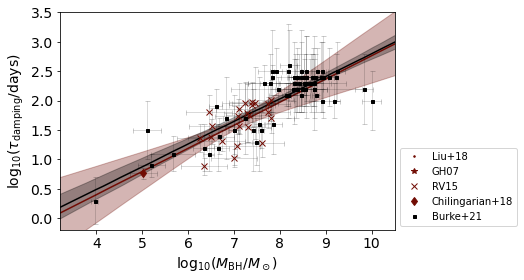

In [29]:
import linmix

def draws_CI_linmix(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i,s in enumerate(samples):
        draws[:, i]  = s['alpha'] + x_eval*s['beta']
    # Compute credibility interval
    draws_credint = np.empty((len(x_eval), 3))
    draws_credint[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint[:, 1] = np.median(draws, axis=1)
    return draws_credint

logM_lm = totmassR
logT_lm = np.log10(tottauR)
logDt_lm = totdlogR
logDm_lm = np.full(len(logDt_lm), 0.4).tolist()

lm = linmix.LinMix(np.array(logM_lm), np.array(logT_lm),
                   xsig = np.array(logDt_lm), ysig = np.array(logDm_lm),
                   K = 2, nchains = 4, seed = np.random.randint(2**31))
lm.run_mcmc(silent = True)
samples_fin = lm.chain

x_eval = np.linspace(0,15,50)
draws_credint = draws_CI_linmix(x_eval, samples_fin)
plt.fill_between(x_eval, draws_credint[:, 2], draws_credint[:, 0], color="#710c04", alpha=0.3, zorder=-5)
plt.plot(x_eval, draws_credint[:, 1], color="#710c04", zorder=-4)

LIU_massR = totmassR[totnameR == 'Liu+18']
LIU_tauR = tottauR[totnameR == 'Liu+18']
LIU_dlogR = totdlogR[totnameR == 'Liu+18']

GH_massR = totmassR[totnameR == 'GH07']
GH_tauR = tottauR[totnameR == 'GH07']
GH_dlogR = totdlogR[totnameR == 'GH07']

RV_massR = totmassR[totnameR == 'RV15']
RV_tauR = tottauR[totnameR == 'RV15']
RV_dlogR = totdlogR[totnameR == 'RV15']

CKZ_massR = totmassR[totnameR == 'Chilingarian+18']
CKZ_tauR = tottauR[totnameR == 'Chilingarian+18']
CKZ_dlogR = totdlogR[totnameR == 'Chilingarian+18']

markL, barL, capL = plt.errorbar(LIU_massR, np.log10(LIU_tauR), xerr = 0.35, yerr = LIU_dlogR, markersize = 3, 
                              fmt ='.', c ='#710c04', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Liu+18')

[b.set_alpha(0.2) for b in barL]
[c.set_alpha(0.2) for c in capL] #0.2

markG, barG, capG = plt.errorbar(GH_massR, np.log10(GH_tauR), xerr = 0.3, yerr = GH_dlogR, 
                              fmt ='*', c ='#710c04', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'GH07')


[b.set_alpha(0.2) for b in barG]
[c.set_alpha(0.2) for c in capG]

markR, barR, capR = plt.errorbar(RV_massR, np.log10(RV_tauR), xerr = 0.5, yerr = RV_dlogR, 
                              fmt ='x', c ='#710c04', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'RV15')

[b.set_alpha(0.2) for b in barR]
[c.set_alpha(0.2) for c in capR]


markC, barC, capC = plt.errorbar(CKZ_massR, np.log10(CKZ_tauR), xerr = 0.3, yerr = CKZ_dlogR, 
                              fmt ='d', c ='#710c04', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Chilingarian+18')

[b.set_alpha(0.2) for b in barC]
[c.set_alpha(0.2) for c in capC]


########
colin_data = ascii.read('colin_data.csv')
CB_massraw = np.array(colin_data['log_M_BH'])
CB_tauraw = np.array(colin_data['log_tau_DRW_rest'])

CB_mass = []
CB_masserr = []
for data in CB_massraw:
    mass_val = data[0] + data[1] + data[2] + data[3]
    err_val = data[8] + data[9] + data[10] + data[11]
    CB_mass.append(float(mass_val))
    CB_masserr.append(float(err_val))

CB_tau = []
CB_tauerr = []
for data in CB_tauraw:
    tau_val = data[0] + data[1] + data[2]
    err_val = data[7] + data[8] + data[9]
    CB_tau.append(float(tau_val))
    CB_tauerr.append(float(err_val))

mark, bar, cap = plt.errorbar(CB_mass, CB_tau, xerr = CB_masserr, yerr = CB_tauerr, markersize = 3,
                              fmt ='s', c ='k', ecolor = 'k', elinewidth = 0.75, capsize = 2.5, label = 'Burke+21')

[b.set_alpha(0.2) for b in bar]
[c.set_alpha(0.2) for c in cap]
########


########
CB_alpha = np.random.normal(107, 11.5, 200)
CB_beta = np.random.normal(0.38, 0.045, 200)
samples_CB = []

p = 0
while p < len(CB_alpha):
    samples_CB.append((CB_alpha[p], CB_beta[p]))
    p += 1
    
CB_samplefin = np.array(samples_CB, dtype=[('alpha', np.float64), ('beta', np.float64)])

def draws_CI_linmix2(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i, s in enumerate(samples):
        draws[:,i] = np.log10(s['alpha']*(10**x_eval/1e8)**s['beta'])
        
    # Compute credibility interval
    draws_credint2 = np.empty((len(x_eval), 3))
    draws_credint2[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint2[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint2[:, 1] = np.median(draws, axis=1)
    return draws_credint2

x_eval2 = np.linspace(0,15,200)
draws_credint2 = draws_CI_linmix2(x_eval2, CB_samplefin)
plt.fill_between(x_eval2, draws_credint2[:, 2], draws_credint2[:, 0], color="k", alpha=0.3, zorder=-5)
plt.plot(x_eval2, draws_credint2[:, 1], color="k", zorder=-4)
#########

#WD_mass = np.log10([0.79432823, 0.72443596, 0.54954087, 0.47863009, 0.58884366, 0.54954087, 0.67608298, 0.75857758])
#WD_tau = np.log10([0.00663572, 0.00591409, 0.01705642, 0.01451737, 0.01418691, 0.00874758, 0.00409155, 0.00895134])
#plt.plot(WD_mass, WD_tau, 'm+', markersize = 15)#, label = 'white dwarfs')

plt.xlabel(r'$\log_{10 }(M_{\rm{BH}}/M_\odot)$', fontsize = 14)
plt.ylabel(r"$\log_{10}(\tau_{\rm{damping}}$/days)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(3.2, 10.5) #(3.2, 10.5)
plt.ylim(-0.2, 3.5) #(-0.2, 3.5)
ax2 = plt.gca()
handles, labels = ax2.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax2.legend(handles, labels, loc='upper left', numpoints=1, bbox_to_anchor = (1.0, 0.4))
plt.savefig('taurestmass_fixedZR_test.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [22]:
LIU_raR = np.array(ra_dataR)[totnameR == 'Liu+18']
LIU_deR = np.array(de_dataR)[totnameR == 'Liu+18']

GH_raR = np.array(ra_dataR)[totnameR == 'GH07']
GH_deR = np.array(de_dataR)[totnameR == 'GH07']

RV_raR = np.array(ra_dataR)[totnameR == 'RV15']
RV_deR = np.array(de_dataR)[totnameR == 'RV15']

CKZ_raR = np.array(ra_dataR)[totnameR == 'Chilingarian+18']
CKZ_deR = np.array(de_dataR)[totnameR == 'Chilingarian+18']

LIU_Rdata = Table([LIU_massR, LIU_tauR, LIU_dlogR, LIU_raR, LIU_deR], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(LIU_Rdata, 'LIU_masstauR62.txt', format = 'ipac')

GH_Rdata = Table([GH_massR, GH_tauR, GH_dlogR, GH_raR, GH_deR], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(GH_Rdata, 'GH_masstauR62.txt', format = 'ipac')

RV_Rdata = Table([RV_massR, RV_tauR, RV_dlogR, RV_raR, RV_deR], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(RV_Rdata, 'RV_masstauR62.txt', format = 'ipac')

CKZ_Rdata = Table([CKZ_massR, CKZ_tauR, CKZ_dlogR, CKZ_raR, CKZ_deR], names = ['mass', 'tau', 'dlog', 'ra', 'dec'])
ascii.write(CKZ_Rdata, 'CKZ_masstauR62.txt', format = 'ipac')

ValueError: Inconsistent data column lengths: {0, 10, 195}

to do: change everything in the r-band section such that it is unique, then create the subplot. It will be a fairly large task of going through and adding one letter to everything, but this will allow each subplot to be separate instead of called under the same lines of code. I have already set ax1 to be for g-band data and ax2 to be for r-band data.

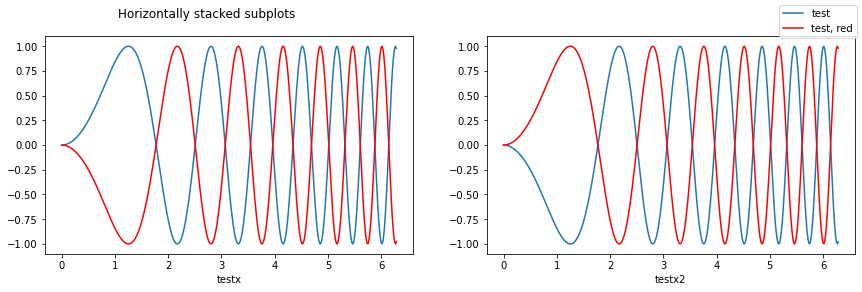

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
fig.subplots_adjust(right = 2)
ax1.plot(x, y, label = 'test')
ax1.plot(x, -y, 'r')
ax1.set_xlabel('testx')
ax2.plot(x, -y)
ax2.plot(x, y, 'r', label = 'test, red')
ax2.set_xlabel('testx2')
fig.legend()


how to subplot: after finishing the to-do above, put everything in the FIRST r-band cell block into before the g-band plotting cell block. See the example above: first call a fig, (ax1, ax2) = plt.subplots(1, 2), and set ax1.plot(x, y) for everything in g-band and ax2.plot for everything in r-band. Might be a bit fiddly with the linmix stuff, but I'm sure you'll figure it out. You'll also have to tweak around with the bar opacities and the no bars in legend.

In [ ]:
CKZ_tautest = timing_analysis(CKZ_mjdfinR[[0]], CKZ_magfinR[[0]], CKZ_errfinR[[0]], CKZ_namesR[[0]], CKZ_oridxR[[0]], 500, 2000, 'CKZ18_zrvar6TEST')

Initial log-likelihood: 210.98600415601499
Final log-likelihood: 343.3782207253715
Running burn-in...
Running production...
